In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states 
from tools.ae_v2 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-05-23 21:27:47.996231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 21:27:47.996951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 21:27:48.066684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 21:27:48.067028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 21:27:48.067315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '004'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_noiseSearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[ 0.8598464 ,  0.20818995, -0.15084821, -0.4832867 , -0.19962065,
         0.18153833],
       [ 0.18234183,  0.22417355,  0.37001276,  0.33698028,  0.34491393,
         0.42713565]], dtype=float32)

# Autoencoder

In [22]:
# setting up training params
learning_rate_list = [1e-3, 1e-4]
epochs = 200
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.2

# stddev = fRMS*timeMeanofSpaceRMS
contractive_lmda = 0.0
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [23]:
all_data = all_data[0:370001]
boundary_idx_arr[0] = 370001

In [24]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = 1 + num_elems_pre_indexing//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [25]:
boundary_idx_arr

array([185001])

In [26]:
all_data.shape

(185001, 6)

In [27]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [28]:
#

In [29]:
# Initialize network
latent_space_dim = 5
# enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
# for i in range(len(enc_layers)):
#     if latent_space_dim < enc_layers[-i-1]:
#         enc_layers = enc_layers[0:-i]
#         break
#     if i == len(enc_layers)-1:
#         enc_layers = []
# dec_layers = enc_layers[::-1]
enc_layers = [16, 8, 8]
dec_layers = [8, 8, 16]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [30]:
#

In [31]:
def optim_func(
        x, # [fRMS, lambda_reg]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    test_mse = trainAE_and_return_testError(
        x, # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    return test_mse

In [32]:
fRMS_bounds = (0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = (1e-6, 1e-3, "log-uniform")
n_calls = 25
acq_func = "EI"
n_initial_points = 5

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0052 - NMSE: 0.0471 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 1.3795 - tot_time: 0h 0m 15.9s

Epoch 1: val_mse improved from inf to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 6ms/step - loss: 0.0055 - mse: 0.0052 - NMSE: 0.0471 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 1.3795 - val_loss: 9.0127e-04 - val_mse:

2312/2313 [============================>.] - ETA: 0s - loss: 4.3914e-04 - mse: 1.8474e-04 - NMSE: 0.0017 - real_MSE: 1.8474e-04 - params_MSE: nan - ls_jacobian_norm: 1.7729 - tot_time: 0h 2m 26.5s

Epoch 10: val_mse improved from 0.00008 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 4.3915e-04 - mse: 1.8475e-04 - NMSE: 0.0017 - real_MSE: 1.8475e-04 - params_MSE: nan - ls_jacobian_norm: 1.7729 - val_loss: 3.2564e-04 - val_mse: 7.3175e-05 - val_NMSE: 6.5857e-04 - val_real_MSE: 7.3175e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2311/2313 [============================>.] - ETA: 0s - loss: 4.3401e-04 - mse: 1.8303e-04 - NMSE: 0.001

2306/2313 [============================>.] - ETA: 0s - loss: 4.0808e-04 - mse: 1.7048e-04 - NMSE: 0.0015 - real_MSE: 1.7048e-04 - params_MSE: nan - ls_jacobian_norm: 1.9143 - tot_time: 0h 4m 54.4s

Epoch 20: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 4.0813e-04 - mse: 1.7053e-04 - NMSE: 0.0015 - real_MSE: 1.7053e-04 - params_MSE: nan - ls_jacobian_norm: 1.9143 - val_loss: 3.1887e-04 - val_mse: 8.1802e-05 - val_NMSE: 7.3621e-04 - val_real_MSE: 8.1802e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2308/2313 [============================>.] - ETA: 0s - loss: 4.0538e-04 - mse: 1.6847e-04 - NMSE: 0.0015 - real_MSE: 1.6847e-04 - params_MSE: nan - ls_jacobian_norm: 1.9210 - tot_time: 0h 5m 9.3s

Epoch 21: val_mse did not improve from 0.00005
 - sa

Epoch 6/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.9863e-04 - mse: 1.5587e-04 - NMSE: 0.0014 - real_MSE: 1.5587e-04 - params_MSE: nan - ls_jacobian_norm: 1.8381 - tot_time: 0h 7m 21.5s

Epoch 6: val_mse improved from 0.00005 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 3.9862e-04 - mse: 1.5585e-04 - NMSE: 0.0014 - real_MSE: 1.5585e-04 - params_MSE: nan - ls_jacobian_norm: 1.8381 - val_loss: 2.9130e-04 - val_mse: 4.8583e-05 - val_NMSE: 4.3725e-04 - val_real_MSE: 4.8583e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.9862e-04 - mse: 1.5598e-04 - N

2309/2313 [============================>.] - ETA: 0s - loss: 3.9526e-04 - mse: 1.5390e-04 - NMSE: 0.0014 - real_MSE: 1.5390e-04 - params_MSE: nan - ls_jacobian_norm: 1.8222 - tot_time: 0h 9m 50.5s

Epoch 16: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 3.9525e-04 - mse: 1.5389e-04 - NMSE: 0.0014 - real_MSE: 1.5389e-04 - params_MSE: nan - ls_jacobian_norm: 1.8222 - val_loss: 2.8802e-04 - val_mse: 4.6758e-05 - val_NMSE: 4.2082e-04 - val_real_MSE: 4.6758e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2306/2313 [============================>.] - ETA: 0s - loss: 3.9502e-04 - mse: 1.5378e-04 - NMSE: 0.0014 - real_MSE: 1.5378e-04 - params_MSE: nan - ls_jacobian_norm: 1.8213 - tot_time: 0h 10m 5.1s

Epoch 17: val_mse did not improve from 0.00004
 - s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0098 - mse: 0.0055 - NMSE: 0.0494 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 1.3582 - val_loss: 0.0050 - val_mse: 0.0012 - val_NMSE: 0.0106 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2303/2313 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 9.8186e-04 - NMSE: 0.0088 - real_MSE: 9.8186e-04 - params_MSE: nan - ls_jacobian_norm: 1.3920 - tot_time: 0h 0m 31.6s

Epoch 2: val_mse improved from 0.00118 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpo

Epoch 11/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 6.0930e-04 - NMSE: 0.0055 - real_MSE: 6.0930e-04 - params_MSE: nan - ls_jacobian_norm: 1.6984 - tot_time: 0h 2m 48.4s

Epoch 11: val_mse improved from 0.00059 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0036 - mse: 6.0928e-04 - NMSE: 0.0055 - real_MSE: 6.0928e-04 - params_MSE: nan - ls_jacobian_norm: 1.6984 - val_loss: 0.0036 - val_mse: 5.8204e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.8204e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 6.0275e-04 - NMSE: 0.0054 - rea

2313/2313 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.7432e-04 - NMSE: 0.0052 - real_MSE: 5.7432e-04 - params_MSE: nan - ls_jacobian_norm: 1.7605 - tot_time: 0h 5m 19.8s

Epoch 21: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0036 - mse: 5.7432e-04 - NMSE: 0.0052 - real_MSE: 5.7432e-04 - params_MSE: nan - ls_jacobian_norm: 1.7605 - val_loss: 0.0036 - val_mse: 5.3827e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3827e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 5.7218e-04 - NMSE: 0.0051 - real_MSE: 5.7218e-04 - params_MSE: nan - ls_jacobian_norm: 1.7649 - tot_time: 0h 5m 34.9s

Epoch 22: val_mse did not improve from 0.00054
 - saving loss histories

Epoch 32/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 5.4394e-04 - NMSE: 0.0049 - real_MSE: 5.4394e-04 - params_MSE: nan - ls_jacobian_norm: 1.8201 - tot_time: 0h 8m 5.7s

Epoch 32: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0036 - mse: 5.4389e-04 - NMSE: 0.0049 - real_MSE: 5.4389e-04 - params_MSE: nan - ls_jacobian_norm: 1.8201 - val_loss: 0.0036 - val_mse: 5.6794e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6794e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 5.4400e-04 - NMSE: 0.0049 - real_MSE: 5.4400e-04 - params_MSE: nan - ls_jacobian_norm: 1.8275 - tot_time: 0h 8m 20.7s

Epoch 33: val_mse improved from 0.00052 to 0.00050, saving 

Epoch 43/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.2725e-04 - NMSE: 0.0047 - real_MSE: 5.2725e-04 - params_MSE: nan - ls_jacobian_norm: 1.8661 - tot_time: 0h 10m 42.1s

Epoch 43: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 5.2725e-04 - NMSE: 0.0047 - real_MSE: 5.2725e-04 - params_MSE: nan - ls_jacobian_norm: 1.8661 - val_loss: 0.0036 - val_mse: 5.0375e-04 - val_NMSE: 0.0045 - val_real_MSE: 5.0375e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 5.2536e-04 - NMSE: 0.0047 - real_MSE: 5.2536e-04 - params_MSE: nan - ls_jacobian_norm: 1.8673 - tot_time: 0h 10m 55.7s

Epoch 44: val_mse did not improve from 0.00049
 - saving

Epoch 54/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 5.2292e-04 - NMSE: 0.0047 - real_MSE: 5.2292e-04 - params_MSE: nan - ls_jacobian_norm: 1.8725 - tot_time: 0h 13m 14.0s

Epoch 54: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 5.2290e-04 - NMSE: 0.0047 - real_MSE: 5.2290e-04 - params_MSE: nan - ls_jacobian_norm: 1.8725 - val_loss: 0.0036 - val_mse: 4.9411e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.9411e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 5.2181e-04 - NMSE: 0.0047 - real_MSE: 5.2181e-04 - params_MSE: nan - ls_jacobian_norm: 1.8738 - tot_time: 0h 13m 28.0s

Epoch 55: val_mse did not improve from 0.00048
 - saving

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 4.9660e-04 - NMSE: 0.0045 - real_MSE: 4.9660e-04 - params_MSE: nan - ls_jacobian_norm: 1.8621 - val_loss: 0.0035 - val_mse: 4.6776e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6776e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 4.9668e-04 - NMSE: 0.0045 - real_MSE: 4.9668e-04 - params_MSE: nan - ls_jacobian_norm: 1.8607 - tot_time: 0h 15m 46.4s

Epoch 8: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 4.9650e-04 - NMSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 4.9564e-04 - NMSE: 0.0045 - real_MSE: 4.9564e-04 - params_MSE: nan - ls_jacobian_norm: 1.8627 - val_loss: 0.0035 - val_mse: 4.7537e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7537e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 4.9641e-04 - NMSE: 0.0045 - real_MSE: 4.9641e-04 - params_MSE: nan - ls_jacobian_norm: 1.8618 - tot_time: 0h 18m 20.0s

Epoch 19: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 4.9637e-04 - NMSE:

2313/2313 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.9404e-04 - NMSE: 0.0044 - real_MSE: 4.9404e-04 - params_MSE: nan - ls_jacobian_norm: 1.8642 - tot_time: 0h 20m 39.2s

Epoch 29: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0036 - mse: 4.9404e-04 - NMSE: 0.0044 - real_MSE: 4.9404e-04 - params_MSE: nan - ls_jacobian_norm: 1.8642 - val_loss: 0.0035 - val_mse: 4.7305e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7305e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 4.9494e-04 - NMSE: 0.0045 - real_MSE: 4.9494e-04 - params_MSE: nan - ls_jacobian_norm: 1.8642Restoring model weights from the end of the best epoch: 20.
 - tot_time: 0h 20m 53.1s

Epoch 30:

Epoch 8/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.1389e-04 - mse: 5.5282e-05 - NMSE: 4.9754e-04 - real_MSE: 5.5282e-05 - params_MSE: nan - ls_jacobian_norm: 1.5734 - tot_time: 0h 2m 0.7s

Epoch 8: val_mse improved from 0.00006 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.1388e-04 - mse: 5.5273e-05 - NMSE: 4.9745e-04 - real_MSE: 5.5273e-05 - params_MSE: nan - ls_jacobian_norm: 1.5735 - val_loss: 2.0477e-04 - val_mse: 4.7777e-05 - val_NMSE: 4.2999e-04 - val_real_MSE: 4.7777e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.0731e-04 - mse: 5.1766e

Epoch 18/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.8049e-04 - mse: 3.8794e-05 - NMSE: 3.4915e-04 - real_MSE: 3.8794e-05 - params_MSE: nan - ls_jacobian_norm: 1.6500 - tot_time: 0h 4m 33.1s

Epoch 18: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.8049e-04 - mse: 3.8798e-05 - NMSE: 3.4918e-04 - real_MSE: 3.8798e-05 - params_MSE: nan - ls_jacobian_norm: 1.6500 - val_loss: 1.7807e-04 - val_mse: 3.6721e-05 - val_NMSE: 3.3049e-04 - val_real_MSE: 3.6721e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
2313/2313 [==============================] - ETA: 0s - loss: 1.7891e-04 - mse: 3.7930e-05 - NMSE: 3.4137e-04 - real_MSE: 3.7930e-05 - params_MSE: nan - ls_jacobian_norm: 1.6517 - tot_time: 0h 4m 48.5s

Epoch 19: val_mse improved

Epoch 28/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.7118e-04 - mse: 3.3970e-05 - NMSE: 3.0573e-04 - real_MSE: 3.3970e-05 - params_MSE: nan - ls_jacobian_norm: 1.6483 - tot_time: 0h 7m 8.9s

Epoch 28: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7119e-04 - mse: 3.3981e-05 - NMSE: 3.0583e-04 - real_MSE: 3.3981e-05 - params_MSE: nan - ls_jacobian_norm: 1.6483 - val_loss: 1.7065e-04 - val_mse: 3.3608e-05 - val_NMSE: 3.0247e-04 - val_real_MSE: 3.3608e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.7021e-04 - mse: 3.3230e-05 - NMSE: 2.9907e-04 - real_MSE: 3.3230e-05 - params_MSE: nan - ls_jacobian_norm: 1.6468 - tot_time: 0h 7m 24.6s

Epoch 29: val_mse did not i

Epoch 39/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.6642e-04 - mse: 3.1151e-05 - NMSE: 2.8035e-04 - real_MSE: 3.1151e-05 - params_MSE: nan - ls_jacobian_norm: 1.6430 - tot_time: 0h 9m 59.9s

Epoch 39: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6643e-04 - mse: 3.1157e-05 - NMSE: 2.8041e-04 - real_MSE: 3.1157e-05 - params_MSE: nan - ls_jacobian_norm: 1.6430 - val_loss: 1.6129e-04 - val_mse: 2.6083e-05 - val_NMSE: 2.3475e-04 - val_real_MSE: 2.6083e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.6615e-04 - mse: 3.1015e-05 - NMSE: 2.7913e-04 - real_MSE: 3.1015e-05 - params_MSE: nan - ls_jacobian_norm: 1.6436 - tot_time: 0h 10m 15.5s

Epoch 40: val_mse did not

Epoch 8/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.6158e-04 - mse: 2.5033e-05 - NMSE: 2.2529e-04 - real_MSE: 2.5033e-05 - params_MSE: nan - ls_jacobian_norm: 1.6166 - tot_time: 0h 12m 35.9s

Epoch 8: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 1.6158e-04 - mse: 2.5024e-05 - NMSE: 2.2522e-04 - real_MSE: 2.5024e-05 - params_MSE: nan - ls_jacobian_norm: 1.6166 - val_loss: 1.5825e-04 - val_mse: 2.1734e-05 - val_NMSE: 1.9561e-04 - val_real_MSE: 2.1734e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.6145e-04 - mse: 2.4928e-05 - NMSE: 2.2435e-04 - real_MSE: 2.4928e-05 - params_MSE: nan - ls_jacobian_norm: 1.6134 - tot_time: 0h 12m 51.8s

Epoch 9: val_mse did not im

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0060 - mse: 0.0052 - NMSE: 0.0465 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 1.3877 - val_loss: 0.0014 - val_mse: 5.8146e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.8146e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 3.1627e-04 - NMSE: 0.0028 - real_MSE: 3.1627e-04 - params_MSE: nan - ls_jacobian_norm: 1.4328 - tot_time: 0h 0m 32.9s

Epoch 2: val_mse improved from 0.00058 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003

2308/2313 [============================>.] - ETA: 0s - loss: 6.9208e-04 - mse: 7.6053e-05 - NMSE: 6.8448e-04 - real_MSE: 7.6053e-05 - params_MSE: nan - ls_jacobian_norm: 1.8934 - tot_time: 0h 2m 55.2s

Epoch 11: val_mse improved from 0.00008 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 6.9210e-04 - mse: 7.6077e-05 - NMSE: 6.8469e-04 - real_MSE: 7.6077e-05 - params_MSE: nan - ls_jacobian_norm: 1.8934 - val_loss: 6.9021e-04 - val_mse: 7.4977e-05 - val_NMSE: 6.7479e-04 - val_real_MSE: 7.4977e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2306/2313 [============================>.] - ETA: 0s - loss: 6.8821e-04 - mse: 7.3507e-05 - NMS

2313/2313 [==============================] - ETA: 0s - loss: 6.7463e-04 - mse: 6.7175e-05 - NMSE: 6.0457e-04 - real_MSE: 6.7175e-05 - params_MSE: nan - ls_jacobian_norm: 1.9422 - tot_time: 0h 5m 31.9s

Epoch 21: val_mse improved from 0.00007 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 6.7463e-04 - mse: 6.7175e-05 - NMSE: 6.0457e-04 - real_MSE: 6.7175e-05 - params_MSE: nan - ls_jacobian_norm: 1.9422 - val_loss: 6.7398e-04 - val_mse: 6.6509e-05 - val_NMSE: 5.9858e-04 - val_real_MSE: 6.6509e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2313/2313 [==============================] - ETA: 0s - loss: 6.7360e-04 - mse: 6.6308e-05 - NMS

2307/2313 [============================>.] - ETA: 0s - loss: 6.6553e-04 - mse: 5.7706e-05 - NMSE: 5.1935e-04 - real_MSE: 5.7706e-05 - params_MSE: nan - ls_jacobian_norm: 1.9398 - tot_time: 0h 8m 7.7s

Epoch 1: val_mse improved from 0.00007 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 6.6552e-04 - mse: 5.7691e-05 - NMSE: 5.1921e-04 - real_MSE: 5.7691e-05 - params_MSE: nan - ls_jacobian_norm: 1.9398 - val_loss: 6.7033e-04 - val_mse: 6.2311e-05 - val_NMSE: 5.6080e-04 - val_real_MSE: 6.2311e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2311/2313 [============================>.] - ETA: 0s - loss: 6.6567e-04 - mse: 5.7569e-05 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 6.6436e-04 - mse: 5.6514e-05 - NMSE: 5.0862e-04 - real_MSE: 5.6514e-05 - params_MSE: nan - ls_jacobian_norm: 1.9105 - val_loss: 6.6930e-04 - val_mse: 6.1429e-05 - val_NMSE: 5.5286e-04 - val_real_MSE: 6.1429e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2312/2313 [============================>.] - ETA: 0s - loss: 6.6414e-04 - mse: 5.6206e-05 - NMSE: 5.0585e-04 - real_MSE: 5.6206e-05 - params_MSE: nan - ls_jacobian_norm: 1.9094 - tot_time: 0h 11m 1.9s

Epoch 12: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchB

/home/rkaushik/Documents/Thesis/MLROM/new_cdv/tools/misc_tools.py:887: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0115 - mse: 0.0055 - NMSE: 0.0497 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 1.3556 - tot_time: 0h 0m 17.5s

Epoch 1: val_mse improved from inf to 0.00134, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0114 - mse: 0.0055 - NMSE: 0.0496 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 1.3556 - val_loss: 0.0064 - val_mse: 0.0

2313/2313 [==============================] - ETA: 0s - loss: 0.0049 - mse: 6.7479e-04 - NMSE: 0.0061 - real_MSE: 6.7479e-04 - params_MSE: nan - ls_jacobian_norm: 1.6362 - tot_time: 0h 2m 22.8s

Epoch 9: val_mse did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0049 - mse: 6.7479e-04 - NMSE: 0.0061 - real_MSE: 6.7479e-04 - params_MSE: nan - ls_jacobian_norm: 1.6362 - val_loss: 0.0050 - val_mse: 7.5891e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.5891e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 6.6660e-04 - NMSE: 0.0060 - real_MSE: 6.6660e-04 - params_MSE: nan - ls_jacobian_norm: 1.6477 - tot_time: 0h 2m 38.5s

Epoch 10: val_mse improved from 0.00075 to 0.00075, saving model to /hom

Epoch 19/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 6.4827e-04 - NMSE: 0.0058 - real_MSE: 6.4827e-04 - params_MSE: nan - ls_jacobian_norm: 1.6855 - tot_time: 0h 5m 0.6s

Epoch 19: val_mse improved from 0.00072 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0049 - mse: 6.4817e-04 - NMSE: 0.0058 - real_MSE: 6.4817e-04 - params_MSE: nan - ls_jacobian_norm: 1.6855 - val_loss: 0.0049 - val_mse: 7.0956e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.0956e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0049 - mse: 6.4564e-04 - NMSE: 0.0058 - real

Epoch 30/200
2304/2313 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 6.4231e-04 - NMSE: 0.0058 - real_MSE: 6.4231e-04 - params_MSE: nan - ls_jacobian_norm: 1.7036 - tot_time: 0h 7m 53.4s

Epoch 30: val_mse did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0049 - mse: 6.4258e-04 - NMSE: 0.0058 - real_MSE: 6.4258e-04 - params_MSE: nan - ls_jacobian_norm: 1.7036 - val_loss: 0.0050 - val_mse: 7.5020e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.5020e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2301/2313 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 6.4228e-04 - NMSE: 0.0058 - real_MSE: 6.4228e-04 - params_MSE: nan - ls_jacobian_norm: 1.7032 - tot_time: 0h 8m 9.3s

Epoch 31: val_mse did not improve from 0.00070
 - saving lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0049 - mse: 6.1682e-04 - NMSE: 0.0056 - real_MSE: 6.1682e-04 - params_MSE: nan - ls_jacobian_norm: 1.6960 - val_loss: 0.0049 - val_mse: 6.9230e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9230e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 6.1638e-04 - NMSE: 0.0055 - real_MSE: 6.1638e-04 - params_MSE: nan - ls_jacobian_norm: 1.6952 - tot_time: 0h 10m 47.8s

Epoch 3: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0049 - mse: 6.1628e-04 - NMSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0048 - mse: 6.1399e-04 - NMSE: 0.0055 - real_MSE: 6.1399e-04 - params_MSE: nan - ls_jacobian_norm: 1.6956 - val_loss: 0.0049 - val_mse: 6.9239e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9239e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 6.1443e-04 - NMSE: 0.0055 - real_MSE: 6.1443e-04 - params_MSE: nan - ls_jacobian_norm: 1.6956 - tot_time: 0h 13m 42.2s

Epoch 14: val_mse improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/

Epoch 24/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 6.1187e-04 - NMSE: 0.0055 - real_MSE: 6.1187e-04 - params_MSE: nan - ls_jacobian_norm: 1.6977 - tot_time: 0h 16m 21.1s

Epoch 24: val_mse did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0048 - mse: 6.1188e-04 - NMSE: 0.0055 - real_MSE: 6.1188e-04 - params_MSE: nan - ls_jacobian_norm: 1.6977 - val_loss: 0.0049 - val_mse: 6.9269e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9269e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 6.1253e-04 - NMSE: 0.0055 - real_MSE: 6.1253e-04 - params_MSE: nan - ls_jacobian_norm: 1.6977 - tot_time: 0h 16m 36.8s

Epoch 25: val_mse did not improve from 0.00068
 - saving

Epoch 35/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 6.1102e-04 - NMSE: 0.0055 - real_MSE: 6.1102e-04 - params_MSE: nan - ls_jacobian_norm: 1.7004 - tot_time: 0h 19m 10.3s

Epoch 35: val_mse did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0048 - mse: 6.1104e-04 - NMSE: 0.0055 - real_MSE: 6.1104e-04 - params_MSE: nan - ls_jacobian_norm: 1.7005 - val_loss: 0.0049 - val_mse: 6.9353e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9353e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 6.1230e-04 - NMSE: 0.0055 - real_MSE: 6.1230e-04 - params_MSE: nan - ls_jacobian_norm: 1.7005 - tot_time: 0h 19m 25.9s

Epoch 36: val_mse did not improve from 0.00068
 - saving

2308/2313 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0057 - NMSE: 0.0511 - real_MSE: 0.0057 - params_MSE: nan - ls_jacobian_norm: 1.3420 - tot_time: 0h 0m 18.0s

Epoch 1: val_mse improved from inf to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 18s 7ms/step - loss: 0.0137 - mse: 0.0057 - NMSE: 0.0510 - real_MSE: 0.0057 - params_MSE: nan - ls_jacobian_norm: 1.3419 - val_loss: 0.0081 - val_mse: 0.0016 - val_NMSE: 0.0143 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0012 - NMSE: 0.0110 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_n

Epoch 11/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 9.3151e-04 - NMSE: 0.0084 - real_MSE: 9.3151e-04 - params_MSE: nan - ls_jacobian_norm: 1.5487 - tot_time: 0h 2m 58.7s

Epoch 11: val_mse improved from 0.00104 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0067 - mse: 9.3175e-04 - NMSE: 0.0084 - real_MSE: 9.3175e-04 - params_MSE: nan - ls_jacobian_norm: 1.5487 - val_loss: 0.0068 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 9.2377e-04 - NMSE: 0.0083 - real_MSE: 9

Epoch 22/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 8.9863e-04 - NMSE: 0.0081 - real_MSE: 8.9863e-04 - params_MSE: nan - ls_jacobian_norm: 1.5741 - tot_time: 0h 5m 50.1s

Epoch 22: val_mse did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0067 - mse: 8.9836e-04 - NMSE: 0.0081 - real_MSE: 8.9836e-04 - params_MSE: nan - ls_jacobian_norm: 1.5741 - val_loss: 0.0068 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 8.9836e-04 - NMSE: 0.0081 - real_MSE: 8.9836e-04 - params_MSE: nan - ls_jacobian_norm: 1.5768 - tot_time: 0h 6m 5.4s

Epoch 23: val_mse improved from 0.00099 to 0.00098, saving model to

Epoch 33/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 8.9187e-04 - NMSE: 0.0080 - real_MSE: 8.9187e-04 - params_MSE: nan - ls_jacobian_norm: 1.5775 - tot_time: 0h 8m 38.5s

Epoch 33: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0067 - mse: 8.9180e-04 - NMSE: 0.0080 - real_MSE: 8.9180e-04 - params_MSE: nan - ls_jacobian_norm: 1.5775 - val_loss: 0.0068 - val_mse: 9.6541e-04 - val_NMSE: 0.0087 - val_real_MSE: 9.6541e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 8.9043e-04 - NMSE: 0.0080 - rea

Epoch 44/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0067 - mse: 8.8889e-04 - NMSE: 0.0080 - real_MSE: 8.8889e-04 - params_MSE: nan - ls_jacobian_norm: 1.5748 - tot_time: 0h 11m 28.3s

Epoch 44: val_mse did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0067 - mse: 8.8889e-04 - NMSE: 0.0080 - real_MSE: 8.8889e-04 - params_MSE: nan - ls_jacobian_norm: 1.5748 - val_loss: 0.0068 - val_mse: 9.9399e-04 - val_NMSE: 0.0089 - val_real_MSE: 9.9399e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 45/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 8.8945e-04 - NMSE: 0.0080 - real_MSE: 8.8945e-04 - params_MSE: nan - ls_jacobian_norm: 1.5739 - tot_time: 0h 11m 43.7s

Epoch 45: val_mse did not improve from 0.00096
 - saving

Epoch 4/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 8.6263e-04 - NMSE: 0.0078 - real_MSE: 8.6263e-04 - params_MSE: nan - ls_jacobian_norm: 1.5700 - tot_time: 0h 14m 17.1s

Epoch 4: val_mse did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0066 - mse: 8.6234e-04 - NMSE: 0.0078 - real_MSE: 8.6234e-04 - params_MSE: nan - ls_jacobian_norm: 1.5700 - val_loss: 0.0068 - val_mse: 9.7526e-04 - val_NMSE: 0.0088 - val_real_MSE: 9.7526e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0066 - mse: 8.6194e-04 - NMSE: 0.0078 - real_MSE: 8.6194e-04 - params_MSE: nan - ls_jacobian_norm: 1.5690 - tot_time: 0h 14m 31.8s

Epoch 5: val_mse did not improve from 0.00096
 - saving los

Epoch 2/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0334 - mse: 0.0107 - NMSE: 0.0963 - real_MSE: 0.0107 - params_MSE: nan - ls_jacobian_norm: 0.9685 - tot_time: 0h 0m 31.6s

Epoch 2: val_mse did not improve from 0.01170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0334 - mse: 0.0107 - NMSE: 0.0963 - real_MSE: 0.0107 - params_MSE: nan - ls_jacobian_norm: 0.9685 - val_loss: 0.0345 - val_mse: 0.0119 - val_NMSE: 0.1070 - val_real_MSE: 0.0119 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0332 - mse: 0.0106 - NMSE: 0.0953 - real_MSE: 0.0106 - params_MSE: nan - ls_jacobian_norm: 0.9851 - tot_time: 0h 0m 46.6s

Epoch 3: val_mse improved from 0.01170 to 0.01152, saving model to /home/rkaushik/Documents/T

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0809 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0493 - val_loss: 0.0336 - val_mse: 0.0097 - val_NMSE: 0.0875 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0809 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0497 - tot_time: 0h 3m 16.6s

Epoch 13: val_mse did not improve from 0.00946
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0809 - real_MSE: 0.0090 - 

Epoch 3/200
2305/2313 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0477 - tot_time: 0h 6m 1.2s

Epoch 3: val_mse did not improve from 0.00946
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0477 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0864 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0475 - tot_time: 0h 6m 16.8s

Epoch 4: val_mse did not improve from 0.00946
 - saving loss histories at /home/rkaushik/Docum

Epoch 15/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0486 - tot_time: 0h 9m 4.9s

Epoch 15: val_mse did not improve from 0.00946
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0486 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0865 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0474 - tot_time: 0h 9m 20.6s

Epoch 16: val_mse did not improve from 0.00946
 - saving loss histories at /home/rkaushik/D

Epoch 4/200
2310/2313 [============================>.] - ETA: 0s - loss: 4.0305e-04 - mse: 3.1404e-04 - NMSE: 0.0028 - real_MSE: 3.1404e-04 - params_MSE: nan - ls_jacobian_norm: 1.5060 - tot_time: 0h 1m 2.4s

Epoch 4: val_mse improved from 0.00017 to 0.00011, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.0305e-04 - mse: 3.1403e-04 - NMSE: 0.0028 - real_MSE: 3.1403e-04 - params_MSE: nan - ls_jacobian_norm: 1.5061 - val_loss: 2.0382e-04 - val_mse: 1.1490e-04 - val_NMSE: 0.0010 - val_real_MSE: 1.1490e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.8236e-04 - mse: 2.9361e-04 - NMSE: 

Epoch 14/200
2313/2313 [==============================] - ETA: 0s - loss: 3.2168e-04 - mse: 2.3811e-04 - NMSE: 0.0021 - real_MSE: 2.3811e-04 - params_MSE: nan - ls_jacobian_norm: 1.8468 - tot_time: 0h 3m 33.3s

Epoch 14: val_mse improved from 0.00007 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 3.2168e-04 - mse: 2.3811e-04 - NMSE: 0.0021 - real_MSE: 2.3811e-04 - params_MSE: nan - ls_jacobian_norm: 1.8468 - val_loss: 1.4021e-04 - val_mse: 5.6868e-05 - val_NMSE: 5.1181e-04 - val_real_MSE: 5.6868e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.2107e-04 - mse: 2.3802e-04 

Epoch 25/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.0320e-04 - mse: 2.2329e-04 - NMSE: 0.0020 - real_MSE: 2.2329e-04 - params_MSE: nan - ls_jacobian_norm: 2.0013 - tot_time: 0h 6m 19.6s

Epoch 25: val_mse improved from 0.00005 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.0320e-04 - mse: 2.2329e-04 - NMSE: 0.0020 - real_MSE: 2.2329e-04 - params_MSE: nan - ls_jacobian_norm: 2.0013 - val_loss: 1.3317e-04 - val_mse: 5.3360e-05 - val_NMSE: 4.8024e-04 - val_real_MSE: 5.3360e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.0205e-04 - mse: 2.2232e-04 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.9493e-04 - mse: 2.1614e-04 - NMSE: 0.0019 - real_MSE: 2.1614e-04 - params_MSE: nan - ls_jacobian_norm: 2.0847 - val_loss: 1.3381e-04 - val_mse: 5.5088e-05 - val_NMSE: 4.9579e-04 - val_real_MSE: 5.5088e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.9371e-04 - mse: 2.1498e-04 - NMSE: 0.0019 - real_MSE: 2.1498e-04 - params_MSE: nan - ls_jacobian_norm: 2.0905 - tot_time: 0h 9m 6.2s

Epoch 36: val_mse improved from 0.00005 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_

Epoch 46/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.8981e-04 - mse: 2.1133e-04 - NMSE: 0.0019 - real_MSE: 2.1133e-04 - params_MSE: nan - ls_jacobian_norm: 2.1631Restoring model weights from the end of the best epoch: 36.
 - tot_time: 0h 11m 37.3s

Epoch 46: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.8982e-04 - mse: 2.1133e-04 - NMSE: 0.0019 - real_MSE: 2.1133e-04 - params_MSE: nan - ls_jacobian_norm: 2.1630 - val_loss: 1.3375e-04 - val_mse: 5.5268e-05 - val_NMSE: 4.9741e-04 - val_real_MSE: 5.5268e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ---------------------------

Epoch 10/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.7302e-04 - mse: 1.9397e-04 - NMSE: 0.0017 - real_MSE: 1.9397e-04 - params_MSE: nan - ls_jacobian_norm: 2.0657 - tot_time: 0h 14m 8.6s

Epoch 10: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.7304e-04 - mse: 1.9399e-04 - NMSE: 0.0017 - real_MSE: 1.9399e-04 - params_MSE: nan - ls_jacobian_norm: 2.0657 - val_loss: 1.1650e-04 - val_mse: 3.7438e-05 - val_NMSE: 3.3694e-04 - val_real_MSE: 3.7438e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.7261e-04 - mse: 1.9354e-04 - NMSE: 0.0017 - real_MSE: 1.9354e-04 - params_MSE: nan - ls_jacobian_norm: 2.0618Restoring model weights from the end of the best epoch: 1.
 - to

Epoch 8/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0167 - mse: 0.0040 - NMSE: 0.0360 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2224 - tot_time: 0h 2m 3.0s

Epoch 8: val_mse did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0167 - mse: 0.0040 - NMSE: 0.0360 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2224 - val_loss: 0.0167 - val_mse: 0.0041 - val_NMSE: 0.0365 - val_real_MSE: 0.0041 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0167 - mse: 0.0040 - NMSE: 0.0360 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2223 - tot_time: 0h 2m 18.0s

Epoch 9: val_mse did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Docum

2311/2313 [============================>.] - ETA: 0s - loss: 0.0167 - mse: 0.0039 - NMSE: 0.0355 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 1.2173 - tot_time: 0h 4m 49.4s

Epoch 4: val_mse did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0167 - mse: 0.0039 - NMSE: 0.0355 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 1.2173 - val_loss: 0.0166 - val_mse: 0.0039 - val_NMSE: 0.0354 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0167 - mse: 0.0039 - NMSE: 0.0355 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 1.2165 - tot_time: 0h 5m 4.9s

Epoch 5: val_mse did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Documents/Thesis/

2305/2313 [============================>.] - ETA: 0s - loss: 0.0166 - mse: 0.0039 - NMSE: 0.0354 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 1.2191 - tot_time: 0h 7m 36.9s

Epoch 15: val_mse did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0166 - mse: 0.0039 - NMSE: 0.0354 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 1.2191 - val_loss: 0.0166 - val_mse: 0.0039 - val_NMSE: 0.0351 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0166 - mse: 0.0039 - NMSE: 0.0354 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 1.2185 - tot_time: 0h 7m 52.4s

Epoch 16: val_mse did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/The

2309/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0055 - NMSE: 0.0492 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 1.3616 - tot_time: 0h 0m 17.7s

Epoch 1: val_mse improved from inf to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 18s 7ms/step - loss: 0.0105 - mse: 0.0055 - NMSE: 0.0491 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 1.3615 - val_loss: 0.0056 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 9.6017e-04 - NMSE: 0.0086 - real_MSE: 9.6017e-04 - params_MSE: nan - ls_ja

Epoch 11/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 5.7484e-04 - NMSE: 0.0052 - real_MSE: 5.7484e-04 - params_MSE: nan - ls_jacobian_norm: 1.6952 - tot_time: 0h 2m 49.8s

Epoch 11: val_mse did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0042 - mse: 5.7492e-04 - NMSE: 0.0052 - real_MSE: 5.7492e-04 - params_MSE: nan - ls_jacobian_norm: 1.6952 - val_loss: 0.0042 - val_mse: 6.4454e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4454e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 5.6830e-04 - NMSE: 0.0051 - real_MSE: 5.6830e-04 - params_MSE: nan - ls_jacobian_norm: 1.7067 - tot_time: 0h 3m 5.1s

Epoch 12: val_mse improved from 0.00064 to 0.00064, saving 

2306/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 5.4436e-04 - NMSE: 0.0049 - real_MSE: 5.4436e-04 - params_MSE: nan - ls_jacobian_norm: 1.7520 - tot_time: 0h 5m 21.9s

Epoch 21: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 5.4441e-04 - NMSE: 0.0049 - real_MSE: 5.4441e-04 - params_MSE: nan - ls_jacobian_norm: 1.7520 - val_loss: 0.0042 - val_mse: 6.0413e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0413e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 5.4150e-04 - NMSE: 0.0049 - real_MSE: 5.4150e-04 - params_MSE: nan - ls_jacobian_norm: 1.7557 - tot_time: 0h 5m 37.0s

Epoch 22: val_mse did not improve from 0.00060
 - saving loss histories

Epoch 32/200
2305/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 5.2691e-04 - NMSE: 0.0047 - real_MSE: 5.2691e-04 - params_MSE: nan - ls_jacobian_norm: 1.7798 - tot_time: 0h 8m 9.6s

Epoch 32: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 5.2673e-04 - NMSE: 0.0047 - real_MSE: 5.2673e-04 - params_MSE: nan - ls_jacobian_norm: 1.7798 - val_loss: 0.0042 - val_mse: 6.1662e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1662e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 5.2753e-04 - NMSE: 0.0047 - real_MSE: 5.2753e-04 - params_MSE: nan - ls_jacobian_norm: 1.7829 - tot_time: 0h 8m 25.0s

Epoch 33: val_mse improved from 0.00058 to 0.00057, saving 

Epoch 43/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 5.1110e-04 - NMSE: 0.0046 - real_MSE: 5.1110e-04 - params_MSE: nan - ls_jacobian_norm: 1.8034 - tot_time: 0h 10m 57.5s

Epoch 43: val_mse did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 5.1122e-04 - NMSE: 0.0046 - real_MSE: 5.1122e-04 - params_MSE: nan - ls_jacobian_norm: 1.8034 - val_loss: 0.0042 - val_mse: 5.8124e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.8124e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 5.0970e-04 - NMSE: 0.0046 - real_MSE: 5.0970e-04 - params_MSE: nan - ls_jacobian_norm: 1.8047 - tot_time: 0h 11m 12.5s

Epoch 44: val_mse improved from 0.00057 to 0.00056, savi

Epoch 54/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.9451e-04 - NMSE: 0.0045 - real_MSE: 4.9451e-04 - params_MSE: nan - ls_jacobian_norm: 1.8293 - tot_time: 0h 13m 45.2s

Epoch 54: val_mse did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0041 - mse: 4.9451e-04 - NMSE: 0.0045 - real_MSE: 4.9451e-04 - params_MSE: nan - ls_jacobian_norm: 1.8293 - val_loss: 0.0042 - val_mse: 5.6303e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6303e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.9485e-04 - NMSE: 0.0045 - real_MSE: 4.9485e-04 - params_MSE: nan - ls_jacobian_norm: 1.8324 - tot_time: 0h 14m 0.7s

Epoch 55: val_mse did not improve from 0.00055
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0041 - mse: 4.7507e-04 - NMSE: 0.0043 - real_MSE: 4.7507e-04 - params_MSE: nan - ls_jacobian_norm: 1.8146 - val_loss: 0.0042 - val_mse: 5.3764e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3764e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 4.7524e-04 - NMSE: 0.0043 - real_MSE: 4.7524e-04 - params_MSE: nan - ls_jacobian_norm: 1.8143 - tot_time: 0h 16m 32.6s

Epoch 6: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 4.7523e-04 - NMSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 4.7167e-04 - NMSE: 0.0042 - real_MSE: 4.7167e-04 - params_MSE: nan - ls_jacobian_norm: 1.8190 - val_loss: 0.0042 - val_mse: 5.4170e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4170e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2304/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 4.7252e-04 - NMSE: 0.0043 - real_MSE: 4.7252e-04 - params_MSE: nan - ls_jacobian_norm: 1.8190 - tot_time: 0h 19m 22.0s

Epoch 17: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 4.7239e-04 - NMSE:

2310/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 4.6981e-04 - NMSE: 0.0042 - real_MSE: 4.6981e-04 - params_MSE: nan - ls_jacobian_norm: 1.8230 - tot_time: 0h 21m 55.9s

Epoch 27: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0041 - mse: 4.6960e-04 - NMSE: 0.0042 - real_MSE: 4.6960e-04 - params_MSE: nan - ls_jacobian_norm: 1.8230 - val_loss: 0.0042 - val_mse: 5.3409e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3409e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 4.7077e-04 - NMSE: 0.0042 - real_MSE: 4.7077e-04 - params_MSE: nan - ls_jacobian_norm: 1.8225 - tot_time: 0h 22m 11.1s

Epoch 28: val_mse did not improve from 0.00053
 - saving loss histori

Epoch 38/200
2304/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 4.6906e-04 - NMSE: 0.0042 - real_MSE: 4.6906e-04 - params_MSE: nan - ls_jacobian_norm: 1.8258 - tot_time: 0h 24m 43.7s

Epoch 38: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0041 - mse: 4.6889e-04 - NMSE: 0.0042 - real_MSE: 4.6889e-04 - params_MSE: nan - ls_jacobian_norm: 1.8258 - val_loss: 0.0042 - val_mse: 5.4030e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4030e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 4.6839e-04 - NMSE: 0.0042 - real_MSE: 4.6839e-04 - params_MSE: nan - ls_jacobian_norm: 1.8269 - tot_time: 0h 24m 59.0s

Epoch 39: val_mse did not improve from 0.00053
 - saving

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0173 - mse: 0.0036 - NMSE: 0.0327 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 1.2326 - val_loss: 0.0176 - val_mse: 0.0040 - val_NMSE: 0.0358 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0173 - mse: 0.0036 - NMSE: 0.0324 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 1.2398 - tot_time: 0h 1m 18.8s

Epoch 5: val_mse improved from 0.00398 to 0.00387, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/Los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0172 - mse: 0.0036 - NMSE: 0.0321 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 1.2374 - val_loss: 0.0175 - val_mse: 0.0038 - val_NMSE: 0.0346 - val_real_MSE: 0.0038 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0172 - mse: 0.0036 - NMSE: 0.0321 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 1.2365 - tot_time: 0h 4m 8.3s

Epoch 16: val_mse did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0172 - mse: 0.0036 - NMSE: 0.0321 - real_MSE: 0.0036 - p

Epoch 2/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0172 - mse: 0.0035 - NMSE: 0.0317 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2343 - tot_time: 0h 6m 59.1s

Epoch 2: val_mse did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0172 - mse: 0.0035 - NMSE: 0.0317 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2343 - val_loss: 0.0175 - val_mse: 0.0039 - val_NMSE: 0.0347 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0172 - mse: 0.0035 - NMSE: 0.0316 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2346 - tot_time: 0h 7m 14.6s

Epoch 3: val_mse did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Docu

579/579 [==============================] - 2s 3ms/step - loss: 0.0175 - mse: 0.0039 - NMSE: 0.0347 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0053 - NMSE: 0.0474 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 1.3789 - tot_time: 0h 0m 18.0s

Epoch 1: val_mse improved from inf to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [========================

Epoch 10/200
2305/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.3706e-04 - NMSE: 0.0012 - real_MSE: 1.3706e-04 - params_MSE: nan - ls_jacobian_norm: 1.8754 - tot_time: 0h 2m 37.7s

Epoch 10: val_mse improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 1.3706e-04 - NMSE: 0.0012 - real_MSE: 1.3706e-04 - params_MSE: nan - ls_jacobian_norm: 1.8754 - val_loss: 0.0016 - val_mse: 1.6754e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6754e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.3692e-04 - NMSE: 0.0012 - rea

Epoch 21/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.3095e-04 - NMSE: 0.0012 - real_MSE: 1.3095e-04 - params_MSE: nan - ls_jacobian_norm: 1.8993 - tot_time: 0h 5m 26.3s

Epoch 21: val_mse improved from 0.00016 to 0.00015, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0016 - mse: 1.3097e-04 - NMSE: 0.0012 - real_MSE: 1.3097e-04 - params_MSE: nan - ls_jacobian_norm: 1.8993 - val_loss: 0.0016 - val_mse: 1.4955e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4955e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.2926e-04 - NMSE: 0.0012 - rea

Epoch 31: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.1693e-04 - NMSE: 0.0011 - real_MSE: 1.1693e-04 - params_MSE: nan - ls_jacobian_norm: 1.8995 - tot_time: 0h 8m 17.9s

Epoch 1: val_mse improved from 0.00015 to 0.00015, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0016 - mse: 1.1685e-04 - NMSE: 0.0011 - real_MSE: 1.1685e-04 - params_MSE: nan - ls_jacobian_n

2311/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.1605e-04 - NMSE: 0.0010 - real_MSE: 1.1605e-04 - params_MSE: nan - ls_jacobian_norm: 1.8873 - tot_time: 0h 10m 53.5s

Epoch 11: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 1.1612e-04 - NMSE: 0.0010 - real_MSE: 1.1612e-04 - params_MSE: nan - ls_jacobian_norm: 1.8873 - val_loss: 0.0016 - val_mse: 1.4685e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4685e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.1575e-04 - NMSE: 0.0010 - real_MSE: 1.1575e-04 - params_MSE: nan - ls_jacobian_norm: 1.8869 - tot_time: 0h 11m 9.3s

Epoch 12: val_mse did not improve from 0.00014
 - saving loss historie

Epoch 22/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.1519e-04 - NMSE: 0.0010 - real_MSE: 1.1519e-04 - params_MSE: nan - ls_jacobian_norm: 1.8882 - tot_time: 0h 13m 43.0s

Epoch 22: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 1.1511e-04 - NMSE: 0.0010 - real_MSE: 1.1511e-04 - params_MSE: nan - ls_jacobian_norm: 1.8882 - val_loss: 0.0016 - val_mse: 1.4336e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4336e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2304/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.1531e-04 - NMSE: 0.0010 - real_MSE: 1.1531e-04 - params_MSE: nan - ls_jacobian_norm: 1.8886 - tot_time: 0h 13m 58.5s

Epoch 23: val_mse improved from 0.00014 to 0.00014, savi

Epoch 6/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.6088e-04 - mse: 2.5510e-04 - NMSE: 0.0023 - real_MSE: 2.5510e-04 - params_MSE: nan - ls_jacobian_norm: 1.5804 - tot_time: 0h 1m 30.4s

Epoch 6: val_mse improved from 0.00009 to 0.00009, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 3.6087e-04 - mse: 2.5509e-04 - NMSE: 0.0023 - real_MSE: 2.5509e-04 - params_MSE: nan - ls_jacobian_norm: 1.5804 - val_loss: 1.9508e-04 - val_mse: 8.9799e-05 - val_NMSE: 8.0819e-04 - val_real_MSE: 8.9799e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.5095e-04 - mse: 2.4617e-04 - N

Epoch 16/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.1203e-04 - mse: 2.1451e-04 - NMSE: 0.0019 - real_MSE: 2.1451e-04 - params_MSE: nan - ls_jacobian_norm: 1.8735 - tot_time: 0h 3m 56.6s

Epoch 16: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 3.1203e-04 - mse: 2.1451e-04 - NMSE: 0.0019 - real_MSE: 2.1451e-04 - params_MSE: nan - ls_jacobian_norm: 1.8735 - val_loss: 1.7505e-04 - val_mse: 7.7823e-05 - val_NMSE: 7.0041e-04 - val_real_MSE: 7.7823e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2307/2313 [============================>.] - ETA: 0s - loss: 3.1055e-04 - mse: 2.1362e-04 - NMSE: 0.0019 - real_MSE: 2.1362e-04 - params_MSE: nan - ls_jacobian_norm: 1.8885 - tot_time: 0h 4m 11.5s

Epoch 17: val_mse did not improve from

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.9348e-04 - mse: 1.9494e-04 - NMSE: 0.0018 - real_MSE: 1.9494e-04 - params_MSE: nan - ls_jacobian_norm: 1.8397 - val_loss: 1.4399e-04 - val_mse: 4.5432e-05 - val_NMSE: 4.0889e-04 - val_real_MSE: 4.5432e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.9346e-04 - mse: 1.9492e-04 - NMSE: 0.0018 - real_MSE: 1.9492e-04 - params_MSE: nan - ls_jacobian_norm: 1.8374 - tot_time: 0h 6m 38.8s

Epoch 3: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.9346e-04 - mse: 1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.8973e-04 - mse: 1.9150e-04 - NMSE: 0.0017 - real_MSE: 1.9150e-04 - params_MSE: nan - ls_jacobian_norm: 1.8162 - val_loss: 1.4114e-04 - val_mse: 4.2924e-05 - val_NMSE: 3.8631e-04 - val_real_MSE: 4.2924e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.8979e-04 - mse: 1.9161e-04 - NMSE: 0.0017 - real_MSE: 1.9161e-04 - params_MSE: nan - ls_jacobian_norm: 1.8157 - tot_time: 0h 9m 5.6s

Epoch 13: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.8980e-04 - mse: 

2304/2313 [============================>.] - ETA: 0s - loss: 2.8681e-04 - mse: 1.8917e-04 - NMSE: 0.0017 - real_MSE: 1.8917e-04 - params_MSE: nan - ls_jacobian_norm: 1.8101 - tot_time: 0h 11m 32.3s

Epoch 23: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.8683e-04 - mse: 1.8919e-04 - NMSE: 0.0017 - real_MSE: 1.8919e-04 - params_MSE: nan - ls_jacobian_norm: 1.8100 - val_loss: 1.3752e-04 - val_mse: 3.9894e-05 - val_NMSE: 3.5905e-04 - val_real_MSE: 3.9894e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.8569e-04 - mse: 1.8810e-04 - NMSE: 0.00

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 3.4118e-04 - mse: 5.7770e-05 - NMSE: 5.1993e-04 - real_MSE: 5.7770e-05 - params_MSE: nan - ls_jacobian_norm: 1.6400 - val_loss: 3.3742e-04 - val_mse: 5.7768e-05 - val_NMSE: 5.1991e-04 - val_real_MSE: 5.7768e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.3063e-04 - mse: 5.4027e-05 - NMSE: 4.8624e-04 - real_MSE: 5.4027e-05 - params_MSE: nan - ls_jacobian_norm: 1.6581 - tot_time: 0h 2m 4.1s

Epoch 8: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBaye

Epoch 17/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.9609e-04 - mse: 4.0269e-05 - NMSE: 3.6242e-04 - real_MSE: 4.0269e-05 - params_MSE: nan - ls_jacobian_norm: 1.7944 - tot_time: 0h 4m 23.6s

Epoch 17: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.9609e-04 - mse: 4.0269e-05 - NMSE: 3.6242e-04 - real_MSE: 4.0269e-05 - params_MSE: nan - ls_jacobian_norm: 1.7944 - val_loss: 2.9863e-04 - val_mse: 4.3236e-05 - val_NMSE: 3.8913e-04 - val_real_MSE: 4.3236e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.9440e-04 - mse: 3.9311e-05 - NMSE: 3.5380e-04 - real_MSE: 3.9311e-05 - params_MSE: nan - ls_jacobian_norm: 1.8034 - tot_time: 0h 4m 39.3s

Epoch 18: val_mse did not 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.8702e-04 - mse: 3.5823e-05 - NMSE: 3.2240e-04 - real_MSE: 3.5823e-05 - params_MSE: nan - ls_jacobian_norm: 1.8287 - val_loss: 2.8771e-04 - val_mse: 3.6679e-05 - val_NMSE: 3.3011e-04 - val_real_MSE: 3.6679e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.8648e-04 - mse: 3.5591e-05 - NMSE: 3.2032e-04 - real_MSE: 3.5591e-05 - params_MSE: nan - ls_jacobian_norm: 1.8298 - tot_time: 0h 7m 12.2s

Epoch 28: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.8649e-0

Epoch 8/200
2309/2313 [============================>.] - ETA: 0s - loss: 2.8415e-04 - mse: 3.0130e-05 - NMSE: 2.7117e-04 - real_MSE: 3.0130e-05 - params_MSE: nan - ls_jacobian_norm: 1.7885 - tot_time: 0h 9m 31.2s

Epoch 8: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.8413e-04 - mse: 3.0114e-05 - NMSE: 2.7102e-04 - real_MSE: 3.0114e-05 - params_MSE: nan - ls_jacobian_norm: 1.7885 - val_loss: 2.8774e-04 - val_mse: 3.3824e-05 - val_NMSE: 3.0441e-04 - val_real_MSE: 3.3824e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2313/2313 [==============================] - ETA: 0s - loss: 2.8391e-04 - mse: 3.0000e-05 - NMSE: 2.7000e-04 - real_MSE: 3.0000e-05 - params_MSE: nan - ls_jacobian_norm: 1.7865 - tot_time: 0h 9m 47.3s

Epoch 9: val_mse did not impr

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0087 - mse: 0.0053 - NMSE: 0.0481 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 1.3712 - val_loss: 0.0042 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0035 - mse: 6.6756e-04 - NMSE: 0.0060 - real_MSE: 6.6756e-04 - params_MSE: nan - ls_jacobian_norm: 1.4228 - tot_time: 0h 0m 33.3s

Epoch 2: val_mse improved from 0.00106 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpo

Epoch 12/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 2.2198e-04 - NMSE: 0.0020 - real_MSE: 2.2198e-04 - params_MSE: nan - ls_jacobian_norm: 1.7723 - tot_time: 0h 3m 9.5s

Epoch 12: val_mse did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0028 - mse: 2.2199e-04 - NMSE: 0.0020 - real_MSE: 2.2199e-04 - params_MSE: nan - ls_jacobian_norm: 1.7723 - val_loss: 0.0028 - val_mse: 2.7748e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.7748e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.2198e-04 - NMSE: 0.0020 - real_MSE: 2.2198e-04 - params_MSE: nan - ls_jacobian_norm: 1.7791 - tot_time: 0h 3m 24.7s

Epoch 13: val_mse did not improve from 0.00026
 - saving lo

Epoch 23/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 2.1749e-04 - NMSE: 0.0020 - real_MSE: 2.1749e-04 - params_MSE: nan - ls_jacobian_norm: 1.8105 - tot_time: 0h 5m 58.2s

Epoch 23: val_mse did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0028 - mse: 2.1749e-04 - NMSE: 0.0020 - real_MSE: 2.1749e-04 - params_MSE: nan - ls_jacobian_norm: 1.8105 - val_loss: 0.0028 - val_mse: 2.6209e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6209e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.1617e-04 - NMSE: 0.0019 - real_MSE: 2.1617e-04 - params_MSE: nan - ls_jacobian_norm: 1.8087 - tot_time: 0h 6m 13.9s

Epoch 24: val_mse did not improve from 0.00025
 - saving l

2307/2313 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 2.0344e-04 - NMSE: 0.0018 - real_MSE: 2.0344e-04 - params_MSE: nan - ls_jacobian_norm: 1.7828 - tot_time: 0h 8m 31.8s

Epoch 8: val_mse did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0028 - mse: 2.0332e-04 - NMSE: 0.0018 - real_MSE: 2.0332e-04 - params_MSE: nan - ls_jacobian_norm: 1.7828 - val_loss: 0.0028 - val_mse: 2.4620e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4620e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 2.0331e-04 - NMSE: 0.0018 - real_MSE: 2.0331e-04 - params_MSE: nan - ls_jacobian_norm: 1.7836 - tot_time: 0h 8m 47.5s

Epoch 9: val_mse did not improve from 0.00025
 - saving loss histories at

Epoch 19/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.0259e-04 - NMSE: 0.0018 - real_MSE: 2.0259e-04 - params_MSE: nan - ls_jacobian_norm: 1.7874 - tot_time: 0h 11m 20.9s

Epoch 19: val_mse did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0028 - mse: 2.0259e-04 - NMSE: 0.0018 - real_MSE: 2.0259e-04 - params_MSE: nan - ls_jacobian_norm: 1.7874 - val_loss: 0.0028 - val_mse: 2.4525e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4525e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 2.0250e-04 - NMSE: 0.0018 - real_MSE: 2.0250e-04 - params_MSE: nan - ls_jacobian_norm: 1.7883 - tot_time: 0h 11m 36.3s

Epoch 20: val_mse did not improve from 0.00024
 - saving

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0032 - mse: 3.8457e-04 - NMSE: 0.0035 - real_MSE: 3.8457e-04 - params_MSE: nan - ls_jacobian_norm: 1.5254 - val_loss: 0.0032 - val_mse: 3.5441e-04 - val_NMSE: 0.0032 - val_real_MSE: 3.5441e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 2.8249e-04 - NMSE: 0.0025 - real_MSE: 2.8249e-04 - params_MSE: nan - ls_jacobian_norm: 1.6164 - tot_time: 0h 1m 3.7s

Epoch 4: val_mse improved from 0.00035 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test

Epoch 14/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.3564e-04 - NMSE: 0.0021 - real_MSE: 2.3564e-04 - params_MSE: nan - ls_jacobian_norm: 1.7630 - tot_time: 0h 3m 38.8s

Epoch 14: val_mse did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0030 - mse: 2.3565e-04 - NMSE: 0.0021 - real_MSE: 2.3565e-04 - params_MSE: nan - ls_jacobian_norm: 1.7631 - val_loss: 0.0030 - val_mse: 2.8022e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8022e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.3538e-04 - NMSE: 0.0021 - real_MSE: 2.3538e-04 - params_MSE: nan - ls_jacobian_norm: 1.7668 - tot_time: 0h 3m 54.5s

Epoch 15: val_mse improved from 0.00028 to 0.00027, saving

Epoch 25/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.3079e-04 - NMSE: 0.0021 - real_MSE: 2.3079e-04 - params_MSE: nan - ls_jacobian_norm: 1.7934Restoring model weights from the end of the best epoch: 15.
 - tot_time: 0h 6m 25.6s

Epoch 25: val_mse did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0030 - mse: 2.3089e-04 - NMSE: 0.0021 - real_MSE: 2.3089e-04 - params_MSE: nan - ls_jacobian_norm: 1.7934 - val_loss: 0.0030 - val_mse: 2.7428e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.7428e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------

Epoch 10/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.1676e-04 - NMSE: 0.0020 - real_MSE: 2.1676e-04 - params_MSE: nan - ls_jacobian_norm: 1.7634 - tot_time: 0h 8m 59.5s

Epoch 10: val_mse did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0030 - mse: 2.1678e-04 - NMSE: 0.0020 - real_MSE: 2.1678e-04 - params_MSE: nan - ls_jacobian_norm: 1.7634 - val_loss: 0.0030 - val_mse: 2.6417e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6417e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.1710e-04 - NMSE: 0.0020 - real_MSE: 2.1710e-04 - params_MSE: nan - ls_jacobian_norm: 1.7646 - tot_time: 0h 9m 14.7s

Epoch 11: val_mse did not improve from 0.00026
 - saving l

Epoch 21/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.1598e-04 - NMSE: 0.0019 - real_MSE: 2.1598e-04 - params_MSE: nan - ls_jacobian_norm: 1.7690 - tot_time: 0h 11m 44.7s

Epoch 21: val_mse did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0030 - mse: 2.1602e-04 - NMSE: 0.0019 - real_MSE: 2.1602e-04 - params_MSE: nan - ls_jacobian_norm: 1.7690 - val_loss: 0.0030 - val_mse: 2.6127e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6127e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.1589e-04 - NMSE: 0.0019 - real_MSE: 2.1589e-04 - params_MSE: nan - ls_jacobian_norm: 1.7693 - tot_time: 0h 11m 60.0s

Epoch 22: val_mse did not improve from 0.00026
 - saving

Epoch 32/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.1502e-04 - NMSE: 0.0019 - real_MSE: 2.1502e-04 - params_MSE: nan - ls_jacobian_norm: 1.7734 - tot_time: 0h 14m 33.9s

Epoch 32: val_mse did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0030 - mse: 2.1488e-04 - NMSE: 0.0019 - real_MSE: 2.1488e-04 - params_MSE: nan - ls_jacobian_norm: 1.7734 - val_loss: 0.0030 - val_mse: 2.6082e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.6082e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 2.1535e-04 - NMSE: 0.0019 - real_MSE: 2.1535e-04 - params_MSE: nan - ls_jacobian_norm: 1.7743Restoring model weights from the end of the best epoch: 23.
 - tot_time: 0h 14m 49.

2303/2313 [============================>.] - ETA: 0s - loss: 0.0217 - mse: 0.0046 - NMSE: 0.0417 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2165 - tot_time: 0h 2m 2.7s

Epoch 8: val_mse did not improve from 0.00488
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0217 - mse: 0.0046 - NMSE: 0.0417 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2165 - val_loss: 0.0220 - val_mse: 0.0050 - val_NMSE: 0.0453 - val_real_MSE: 0.0050 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0217 - mse: 0.0046 - NMSE: 0.0417 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2174 - tot_time: 0h 2m 17.8s

Epoch 9: val_mse did not improve from 0.00488
 - saving loss histories at /home/rkaushik/Documents/Thesis/

Epoch 19/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0041 - NMSE: 0.0366 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 1.2412 - tot_time: 0h 4m 48.7s

Epoch 19: val_mse improved from 0.00439 to 0.00437, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0216 - mse: 0.0041 - NMSE: 0.0366 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 1.2412 - val_loss: 0.0219 - val_mse: 0.0044 - val_NMSE: 0.0393 - val_real_MSE: 0.0044 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0364 - real_MSE: 0.0040 - params_MSE: 

Epoch 30/200
2303/2313 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0362 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2427 - tot_time: 0h 7m 36.4s

Epoch 30: val_mse did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0362 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2427 - val_loss: 0.0220 - val_mse: 0.0045 - val_NMSE: 0.0406 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0362 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2423 - tot_time: 0h 7m 51.8s

Epoch 31: val_mse improved from 0.00431 to 0.00429, saving model to /home/rkaushik/Documen

2307/2313 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0362 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2425 - tot_time: 0h 10m 22.1s

Epoch 41: val_mse did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0362 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2426 - val_loss: 0.0219 - val_mse: 0.0043 - val_NMSE: 0.0386 - val_real_MSE: 0.0043 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0040 - NMSE: 0.0361 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2430 - tot_time: 0h 10m 37.1s

Epoch 42: val_mse did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/T

2308/2313 [============================>.] - ETA: 0s - loss: 0.0215 - mse: 0.0040 - NMSE: 0.0357 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2397 - tot_time: 0h 13m 8.5s

Epoch 3: val_mse did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0215 - mse: 0.0040 - NMSE: 0.0357 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2397 - val_loss: 0.0219 - val_mse: 0.0043 - val_NMSE: 0.0388 - val_real_MSE: 0.0043 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0215 - mse: 0.0040 - NMSE: 0.0356 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 1.2401 - tot_time: 0h 13m 23.4s

Epoch 4: val_mse did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/Thesi

2313/2313 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0057 - NMSE: 0.0512 - real_MSE: 0.0057 - params_MSE: nan - ls_jacobian_norm: 1.3335 - tot_time: 0h 0m 14.9s

Epoch 1: val_mse improved from inf to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0069 - mse: 0.0057 - NMSE: 0.0512 - real_MSE: 0.0057 - params_MSE: nan - ls_jacobian_norm: 1.3334 - val_loss: 0.0021 - val_mse: 8.2694e-04 - val_NMSE: 0.0074 - val_real_MSE: 8.2694e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 9.5584e-04 - NMSE: 0.0086 - real_MSE: 9.5584e-04 - params_MSE: nan

Epoch 11/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.8583e-04 - NMSE: 0.0062 - real_MSE: 6.8583e-04 - params_MSE: nan - ls_jacobian_norm: 1.8433 - tot_time: 0h 2m 46.5s

Epoch 11: val_mse did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 6.8585e-04 - NMSE: 0.0062 - real_MSE: 6.8585e-04 - params_MSE: nan - ls_jacobian_norm: 1.8432 - val_loss: 0.0012 - val_mse: 2.4751e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4751e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.7875e-04 - NMSE: 0.0061 - real_MSE: 6.7875e-04 - params_MSE: nan - ls_jacobian_norm: 1.8532 - tot_time: 0h 3m 2.0s

Epoch 12: val_mse did not improve from 0.00021
 - saving lo

Epoch 22/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.6553e-04 - NMSE: 0.0060 - real_MSE: 6.6553e-04 - params_MSE: nan - ls_jacobian_norm: 1.8786 - tot_time: 0h 5m 34.6s

Epoch 22: val_mse improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 6.6544e-04 - NMSE: 0.0060 - real_MSE: 6.6544e-04 - params_MSE: nan - ls_jacobian_norm: 1.8786 - val_loss: 0.0011 - val_mse: 1.9893e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9893e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0016 - mse: 6.6274e-04 - NMSE: 0.0060 - rea

Epoch 33/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.5885e-04 - NMSE: 0.0059 - real_MSE: 6.5885e-04 - params_MSE: nan - ls_jacobian_norm: 1.8608 - tot_time: 0h 8m 22.9s

Epoch 33: val_mse did not improve from 0.00019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 6.5880e-04 - NMSE: 0.0059 - real_MSE: 6.5880e-04 - params_MSE: nan - ls_jacobian_norm: 1.8609 - val_loss: 0.0012 - val_mse: 2.2361e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2361e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
2305/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.5376e-04 - NMSE: 0.0059 - real_MSE: 6.5376e-04 - params_MSE: nan - ls_jacobian_norm: 1.8537Restoring model weights from the end of the best epoch: 24.
 - tot_time: 0h 8m 38.3s

Epoch 9/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.2465e-04 - NMSE: 0.0056 - real_MSE: 6.2465e-04 - params_MSE: nan - ls_jacobian_norm: 1.8369 - tot_time: 0h 10m 57.4s

Epoch 9: val_mse did not improve from 0.00017
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0016 - mse: 6.2464e-04 - NMSE: 0.0056 - real_MSE: 6.2464e-04 - params_MSE: nan - ls_jacobian_norm: 1.8369 - val_loss: 0.0011 - val_mse: 1.7629e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.7629e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.2465e-04 - NMSE: 0.0056 - real_MSE: 6.2465e-04 - params_MSE: nan - ls_jacobian_norm: 1.8347 - tot_time: 0h 11m 13.0s

Epoch 10: val_mse did not improve from 0.00017
 - saving l

Epoch 20/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.2272e-04 - NMSE: 0.0056 - real_MSE: 6.2272e-04 - params_MSE: nan - ls_jacobian_norm: 1.8230 - tot_time: 0h 13m 47.5s

Epoch 20: val_mse did not improve from 0.00017
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0016 - mse: 6.2272e-04 - NMSE: 0.0056 - real_MSE: 6.2272e-04 - params_MSE: nan - ls_jacobian_norm: 1.8230 - val_loss: 0.0011 - val_mse: 1.6792e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6792e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0016 - mse: 6.2332e-04 - NMSE: 0.0056 - real_MSE: 6.2332e-04 - params_MSE: nan - ls_jacobian_norm: 1.8223 - tot_time: 0h 14m 2.9s

Epoch 21: val_mse did not improve from 0.00017
 - saving 

2313/2313 [==============================] - ETA: 0s - loss: 0.0012 - mse: 7.3563e-04 - NMSE: 0.0066 - real_MSE: 7.3563e-04 - params_MSE: nan - ls_jacobian_norm: 1.6279 - tot_time: 0h 1m 14.4s

Epoch 5: val_mse improved from 0.00024 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0012 - mse: 7.3563e-04 - NMSE: 0.0066 - real_MSE: 7.3563e-04 - params_MSE: nan - ls_jacobian_norm: 1.6279 - val_loss: 6.7305e-04 - val_mse: 2.0080e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0080e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0012 - mse: 7.1783e-04 - NMSE: 0.0065 - real_MSE: 7.17

Epoch 15/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 6.4708e-04 - NMSE: 0.0058 - real_MSE: 6.4708e-04 - params_MSE: nan - ls_jacobian_norm: 1.9715 - tot_time: 0h 3m 39.3s

Epoch 15: val_mse did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0011 - mse: 6.4712e-04 - NMSE: 0.0058 - real_MSE: 6.4712e-04 - params_MSE: nan - ls_jacobian_norm: 1.9715 - val_loss: 6.0042e-04 - val_mse: 1.6951e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6951e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 6.4230e-04 - NMSE: 0.0058 - real_MSE: 6.4230e-04 - params_MSE: nan - ls_jacobian_norm: 1.9985 - tot_time: 0h 3m 53.7s

Epoch 16: val_mse improved from 0.00016 to 0.00015, sa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0010 - mse: 6.2205e-04 - NMSE: 0.0056 - real_MSE: 6.2205e-04 - params_MSE: nan - ls_jacobian_norm: 2.1001 - val_loss: 5.8748e-04 - val_mse: 1.6007e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.6007e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.2161e-04 - NMSE: 0.0056 - real_MSE: 6.2161e-04 - params_MSE: nan - ls_jacobian_norm: 2.1112 - tot_time: 0h 6m 18.3s

Epoch 26: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0010 - mse: 6.2163e-04 - NM

Epoch 2/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 5.8959e-04 - NMSE: 0.0053 - real_MSE: 5.8959e-04 - params_MSE: nan - ls_jacobian_norm: 2.0896 - tot_time: 0h 8m 43.1s

Epoch 2: val_mse improved from 0.00012 to 0.00012, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0010 - mse: 5.8952e-04 - NMSE: 0.0053 - real_MSE: 5.8952e-04 - params_MSE: nan - ls_jacobian_norm: 2.0896 - val_loss: 5.4613e-04 - val_mse: 1.1742e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.1742e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 5.8778e-04 - NMSE: 0.0053 - re

Epoch 13/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 5.8522e-04 - NMSE: 0.0053 - real_MSE: 5.8522e-04 - params_MSE: nan - ls_jacobian_norm: 2.0619 - tot_time: 0h 11m 21.0s

Epoch 13: val_mse did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0010 - mse: 5.8528e-04 - NMSE: 0.0053 - real_MSE: 5.8528e-04 - params_MSE: nan - ls_jacobian_norm: 2.0620 - val_loss: 5.4292e-04 - val_mse: 1.1391e-04 - val_NMSE: 0.0010 - val_real_MSE: 1.1391e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 5.8376e-04 - NMSE: 0.0053 - real_MSE: 5.8376e-04 - params_MSE: nan - ls_jacobian_norm: 2.0613 - tot_time: 0h 11m 35.6s

Epoch 14: val_mse improved from 0.00011 to 0.00011, 

Epoch 24/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 5.8504e-04 - NMSE: 0.0053 - real_MSE: 5.8504e-04 - params_MSE: nan - ls_jacobian_norm: 2.0540Restoring model weights from the end of the best epoch: 14.
 - tot_time: 0h 13m 57.9s

Epoch 24: val_mse did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0010 - mse: 5.8504e-04 - NMSE: 0.0053 - real_MSE: 5.8504e-04 - params_MSE: nan - ls_jacobian_norm: 2.0540 - val_loss: 5.4134e-04 - val_mse: 1.1270e-04 - val_NMSE: 0.0010 - val_real_MSE: 1.1270e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24: early stopping
579/579 [==============================] - 2s 3ms/step - loss: 5.3818e-04 - mse: 1.0911e-04 - NMSE: 9.8197e-04 - real_MSE: 1.0911e-04 - params_MSE: nan - ls_jacobian_norm: -1.

Epoch 9/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0106 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 1.4329 - tot_time: 0h 2m 18.3s

Epoch 9: val_mse improved from 0.00153 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0106 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 1.4329 - val_loss: 0.0107 - val_mse: 0.0015 - val_NMSE: 0.0137 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0014 - NMSE: 0.0122 - real_MSE: 0.0014 - params_MSE: na

Epoch 20/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0121 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4624 - tot_time: 0h 5m 3.5s

Epoch 20: val_mse did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0121 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4623 - val_loss: 0.0107 - val_mse: 0.0015 - val_NMSE: 0.0133 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0120 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4637 - tot_time: 0h 5m 18.2s

Epoch 21: val_mse did not improve from 0.00147
 - saving loss histories at /home/rkaushik/D

Epoch 31/200
2303/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4740 - tot_time: 0h 7m 47.7s

Epoch 31: val_mse did not improve from 0.00142
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4740 - val_loss: 0.0106 - val_mse: 0.0015 - val_NMSE: 0.0133 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4747 - tot_time: 0h 8m 2.6s

Epoch 32: val_mse did not improve from 0.00142
 - saving loss histories at /home/rkaushik/D

2306/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4699 - tot_time: 0h 10m 33.0s

Epoch 42: val_mse did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4699 - val_loss: 0.0106 - val_mse: 0.0015 - val_NMSE: 0.0132 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4703 - tot_time: 0h 10m 48.2s

Epoch 43: val_mse did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/T

2307/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4666 - tot_time: 0h 13m 18.6s

Epoch 2: val_mse did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4666 - val_loss: 0.0106 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.4666 - tot_time: 0h 13m 33.8s

Epoch 3: val_mse did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thes

579/579 [==============================] - 2s 3ms/step - loss: 0.0106 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0053 - NMSE: 0.0476 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 1.3765 - tot_time: 0h 0m 16.0s

Epoch 1: val_mse improved from inf to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [========================

Epoch 10/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.6573e-04 - NMSE: 0.0015 - real_MSE: 1.6573e-04 - params_MSE: nan - ls_jacobian_norm: 1.8658 - tot_time: 0h 2m 23.5s

Epoch 10: val_mse improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0016 - mse: 1.6578e-04 - NMSE: 0.0015 - real_MSE: 1.6578e-04 - params_MSE: nan - ls_jacobian_norm: 1.8659 - val_loss: 0.0016 - val_mse: 1.6700e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6700e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.6589e-04 - NMSE: 0.0015 - rea

Epoch 21/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.5927e-04 - NMSE: 0.0014 - real_MSE: 1.5927e-04 - params_MSE: nan - ls_jacobian_norm: 1.8954 - tot_time: 0h 4m 58.2s

Epoch 21: val_mse improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0016 - mse: 1.5927e-04 - NMSE: 0.0014 - real_MSE: 1.5927e-04 - params_MSE: nan - ls_jacobian_norm: 1.8954 - val_loss: 0.0016 - val_mse: 1.5828e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5828e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.5822e-04 - NMSE: 0.0014 - rea

Epoch 32/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.5460e-04 - NMSE: 0.0014 - real_MSE: 1.5460e-04 - params_MSE: nan - ls_jacobian_norm: 1.9074 - tot_time: 0h 7m 33.3s

Epoch 32: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0016 - mse: 1.5454e-04 - NMSE: 0.0014 - real_MSE: 1.5454e-04 - params_MSE: nan - ls_jacobian_norm: 1.9074 - val_loss: 0.0016 - val_mse: 1.6206e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6206e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2303/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.5463e-04 - NMSE: 0.0014 - real_MSE: 1.5463e-04 - params_MSE: nan - ls_jacobian_norm: 1.9095 - tot_time: 0h 7m 47.2s

Epoch 33: val_mse did not improve from 0.00015
 - saving l

2306/2313 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 1.4137e-04 - NMSE: 0.0013 - real_MSE: 1.4137e-04 - params_MSE: nan - ls_jacobian_norm: 1.8867 - tot_time: 0h 9m 54.9s

Epoch 6: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 0.0016 - mse: 1.4132e-04 - NMSE: 0.0013 - real_MSE: 1.4132e-04 - params_MSE: nan - ls_jacobian_norm: 1.8867 - val_loss: 0.0016 - val_mse: 1.4295e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4295e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.4129e-04 - NMSE: 0.0013 - real_MSE: 1.4129e-04 - params_MSE: nan - ls_jacobian_norm: 1.8874 - tot_time: 0h 10m 9.0s

Epoch 7: val_mse did not improve from 0.00014
 - saving loss histories at

579/579 [==============================] - 2s 3ms/step - loss: 0.0016 - mse: 1.4271e-04 - NMSE: 0.0013 - real_MSE: 1.4271e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2308/2313 [============================>.] - ETA: 0s - loss: 0.0250 - mse: 0.0074 - NMSE: 0.0669 - real_MSE: 0.0074 - params_MSE: nan - ls_jacobian_norm: 1.2869 - tot_time: 0h 0m 17.4s

Epoch 1: val_mse improved from inf to 0.00425, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [================

Epoch 11/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0155 - mse: 0.0035 - NMSE: 0.0311 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2449 - tot_time: 0h 2m 51.0s

Epoch 11: val_mse did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0155 - mse: 0.0035 - NMSE: 0.0311 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2449 - val_loss: 0.0158 - val_mse: 0.0037 - val_NMSE: 0.0336 - val_real_MSE: 0.0037 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0155 - mse: 0.0035 - NMSE: 0.0311 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 1.2435 - tot_time: 0h 3m 6.3s

Epoch 12: val_mse did not improve from 0.00373
 - saving loss histories at /home/rkaushik/D

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0155 - mse: 0.0034 - NMSE: 0.0310 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 1.2346 - val_loss: 0.0159 - val_mse: 0.0038 - val_NMSE: 0.0343 - val_real_MSE: 0.0038 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0155 - mse: 0.0034 - NMSE: 0.0310 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 1.2344 - tot_time: 0h 5m 52.6s

Epoch 23: val_mse did not improve from 0.00372
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0155 - mse: 0.0034 - NMSE: 0.0310 - real_MSE: 0.0034 - 

2309/2313 [============================>.] - ETA: 0s - loss: 0.0155 - mse: 0.0034 - NMSE: 0.0306 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 1.2369 - tot_time: 0h 8m 22.0s

Epoch 8: val_mse did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0155 - mse: 0.0034 - NMSE: 0.0306 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 1.2369 - val_loss: 0.0158 - val_mse: 0.0037 - val_NMSE: 0.0337 - val_real_MSE: 0.0037 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2310/2313 [============================>.] - ETA: 0s - loss: 0.0155 - mse: 0.0034 - NMSE: 0.0306 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 1.2369 - tot_time: 0h 8m 37.2s

Epoch 9: val_mse did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0074 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.4690 - val_loss: 0.0074 - val_mse: 0.0012 - val_NMSE: 0.0104 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0074 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.4796 - tot_time: 0h 1m 31.7s

Epoch 6: val_mse improved from 0.00115 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/Los

Epoch 16/200
2306/2313 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.5149 - tot_time: 0h 4m 1.7s

Epoch 16: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0073 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.5149 - val_loss: 0.0074 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.5182 - tot_time: 0h 4m 16.8s

Epoch 17: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/D

Epoch 2/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 1.5092 - tot_time: 0h 6m 50.4s

Epoch 2: val_mse improved from 0.00109 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0073 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 1.5093 - val_loss: 0.0073 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan

579/579 [==============================] - 2s 3ms/step - loss: 0.0073 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2313/2313 [==============================] - ETA: 0s - loss: 0.0057 - mse: 0.0052 - NMSE: 0.0464 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 1.3905 - tot_time: 0h 0m 17.7s

Epoch 1: val_mse improved from inf to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [========================

Epoch 10/200
2309/2313 [============================>.] - ETA: 0s - loss: 4.8151e-04 - mse: 6.5760e-05 - NMSE: 5.9184e-04 - real_MSE: 6.5760e-05 - params_MSE: nan - ls_jacobian_norm: 1.8061 - tot_time: 0h 2m 35.9s

Epoch 10: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.8153e-04 - mse: 6.5780e-05 - NMSE: 5.9202e-04 - real_MSE: 6.5780e-05 - params_MSE: nan - ls_jacobian_norm: 1.8061 - val_loss: 4.8443e-04 - val_mse: 7.0496e-05 - val_NMSE: 6.3446e-04 - val_real_MSE: 7.0496e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2312/2313 [============================>.] - ETA: 0s - loss: 4.7687e-04 - mse: 6.3916e-05 - NMSE: 5.7524e-04 - real_MSE: 6.3916e-05 - params_MSE: nan - ls_jacobian_norm: 1.8285 - tot_time: 0h 2m 51.4s

Epoch 11: val_mse improved

Epoch 21/200
2305/2313 [============================>.] - ETA: 0s - loss: 4.5841e-04 - mse: 5.5610e-05 - NMSE: 5.0049e-04 - real_MSE: 5.5610e-05 - params_MSE: nan - ls_jacobian_norm: 1.9259 - tot_time: 0h 5m 23.7s

Epoch 21: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.5841e-04 - mse: 5.5604e-05 - NMSE: 5.0043e-04 - real_MSE: 5.5604e-05 - params_MSE: nan - ls_jacobian_norm: 1.9259 - val_loss: 4.5943e-04 - val_mse: 5.6832e-05 - val_NMSE: 5.1149e-04 - val_real_MSE: 5.6832e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2311/2313 [============================>.] - ETA: 0s - loss: 4.5759e-04 - mse: 5.5081e-05 - NMSE: 4.9573e-04 - real_MSE: 5.5081e-05 - params_MSE: nan - ls_jacobian_norm: 1.9283 - tot_time: 0h 5m 39.1s

Epoch 22: val_mse did not 

Epoch 6/200
2311/2313 [============================>.] - ETA: 0s - loss: 4.5497e-04 - mse: 4.8729e-05 - NMSE: 4.3856e-04 - real_MSE: 4.8729e-05 - params_MSE: nan - ls_jacobian_norm: 1.8821 - tot_time: 0h 7m 57.2s

Epoch 6: val_mse improved from 0.00005 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.5497e-04 - mse: 4.8725e-05 - NMSE: 4.3852e-04 - real_MSE: 4.8725e-05 - params_MSE: nan - ls_jacobian_norm: 1.8820 - val_loss: 4.5418e-04 - val_mse: 4.7951e-05 - val_NMSE: 4.3155e-04 - val_real_MSE: 4.7951e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2308/2313 [============================>.] - ETA: 0s - loss: 4.5466e-04 - mse: 4.8509

Epoch 16/200
2310/2313 [============================>.] - ETA: 0s - loss: 4.5234e-04 - mse: 4.7151e-05 - NMSE: 4.2436e-04 - real_MSE: 4.7151e-05 - params_MSE: nan - ls_jacobian_norm: 1.8706Restoring model weights from the end of the best epoch: 6.
 - tot_time: 0h 10m 29.8s

Epoch 16: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.5234e-04 - mse: 4.7149e-05 - NMSE: 4.2434e-04 - real_MSE: 4.7149e-05 - params_MSE: nan - ls_jacobian_norm: 1.8706 - val_loss: 4.5302e-04 - val_mse: 4.8001e-05 - val_NMSE: 4.3201e-04 - val_real_MSE: 4.8001e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16: early stopping
579/579 [==============================] - 2s 3ms/step - loss: 4.5418e-04 - mse: 4.7951e-05 - NMSE: 4.3155e-04 - real_MSE: 4.7951e-05 - params_MSE: nan - ls

2306/2313 [============================>.] - ETA: 0s - loss: 4.3776e-04 - mse: 6.0235e-05 - NMSE: 5.4211e-04 - real_MSE: 6.0235e-05 - params_MSE: nan - ls_jacobian_norm: 1.7294 - tot_time: 0h 2m 4.1s

Epoch 8: val_mse improved from 0.00007 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.3773e-04 - mse: 6.0208e-05 - NMSE: 5.4187e-04 - real_MSE: 6.0208e-05 - params_MSE: nan - ls_jacobian_norm: 1.7294 - val_loss: 4.3601e-04 - val_mse: 6.1723e-05 - val_NMSE: 5.5551e-04 - val_real_MSE: 6.1723e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2303/2313 [============================>.] - ETA: 0s - loss: 4.2918e-04 - mse: 5.7017e-05 - NMSE: 

Epoch 18/200
2310/2313 [============================>.] - ETA: 0s - loss: 4.0336e-04 - mse: 4.6340e-05 - NMSE: 4.1706e-04 - real_MSE: 4.6340e-05 - params_MSE: nan - ls_jacobian_norm: 1.8865 - tot_time: 0h 4m 36.9s

Epoch 18: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.0338e-04 - mse: 4.6355e-05 - NMSE: 4.1719e-04 - real_MSE: 4.6355e-05 - params_MSE: nan - ls_jacobian_norm: 1.8864 - val_loss: 4.0924e-04 - val_mse: 5.2501e-05 - val_NMSE: 4.7251e-04 - val_real_MSE: 5.2501e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
2307/2313 [============================>.] - ETA: 0s - loss: 4.0234e-04 - mse: 4.5927e-05 - NMSE: 4.1334e-04 - real_MSE: 4.5927e-05 - params_MSE: nan - ls_jacobian_norm: 1.8897 - tot_time: 0h 4m 52.2s

Epoch 19: val_mse improved

Epoch 29/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.9622e-04 - mse: 4.3169e-05 - NMSE: 3.8852e-04 - real_MSE: 4.3169e-05 - params_MSE: nan - ls_jacobian_norm: 1.9118 - tot_time: 0h 7m 22.8s

Epoch 29: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 3.9622e-04 - mse: 4.3170e-05 - NMSE: 3.8853e-04 - real_MSE: 4.3170e-05 - params_MSE: nan - ls_jacobian_norm: 1.9118 - val_loss: 4.0122e-04 - val_mse: 4.8815e-05 - val_NMSE: 4.3934e-04 - val_real_MSE: 4.8815e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
2313/2313 [==============================] - ETA: 0s - loss: 3.9581e-04 - mse: 4.3096e-05 - NMSE: 3.8786e-04 - real_MSE: 4.3096e-05 - params_MSE: nan - ls_jacobian_norm: 1.9163 - tot_time: 0h 7m 38.0s

Epoch 30: val_mse did not 

Epoch 7/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.9100e-04 - mse: 3.6112e-05 - NMSE: 3.2500e-04 - real_MSE: 3.6112e-05 - params_MSE: nan - ls_jacobian_norm: 1.8783 - tot_time: 0h 9m 55.1s

Epoch 7: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 3.9100e-04 - mse: 3.6108e-05 - NMSE: 3.2497e-04 - real_MSE: 3.6108e-05 - params_MSE: nan - ls_jacobian_norm: 1.8783 - val_loss: 3.9677e-04 - val_mse: 4.1870e-05 - val_NMSE: 3.7683e-04 - val_real_MSE: 4.1870e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2307/2313 [============================>.] - ETA: 0s - loss: 3.9088e-04 - mse: 3.5959e-05 - NMSE: 3.2363e-04 - real_MSE: 3.5959e-05 - params_MSE: nan - ls_jacobian_norm: 1.8754 - tot_time: 0h 10m 10.2s

Epoch 8: val_mse did not imp

579/579 [==============================] - 2s 3ms/step - loss: 3.9547e-04 - mse: 4.0515e-05 - NMSE: 3.6463e-04 - real_MSE: 4.0515e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


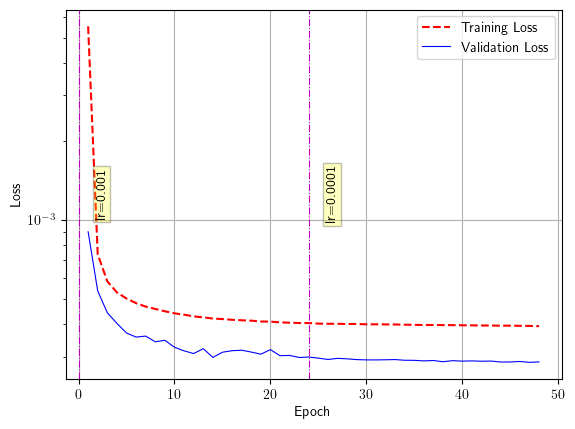

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

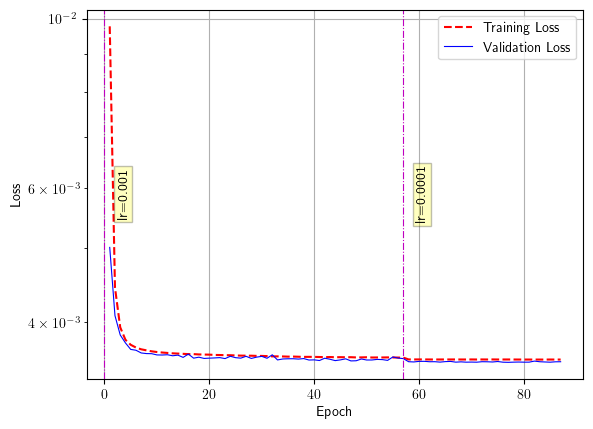

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

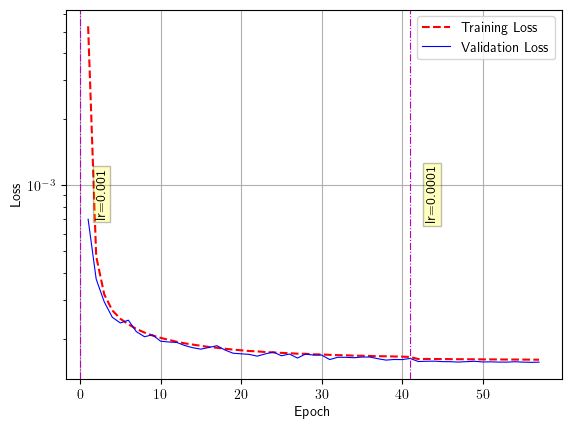

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

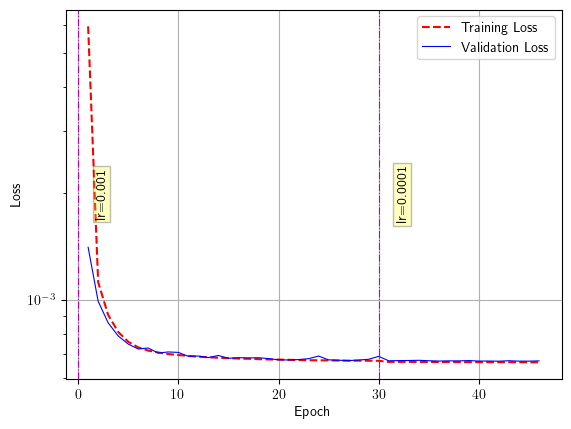

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

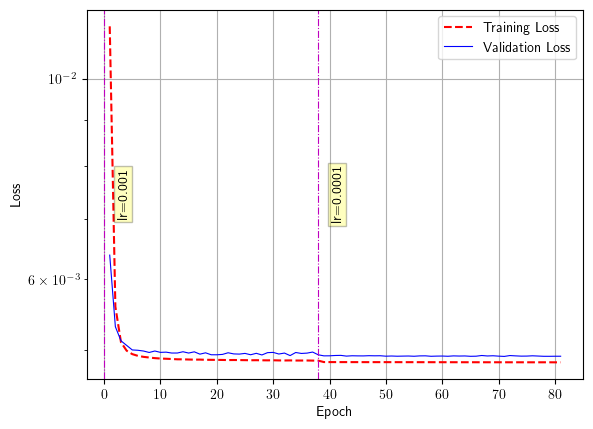

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

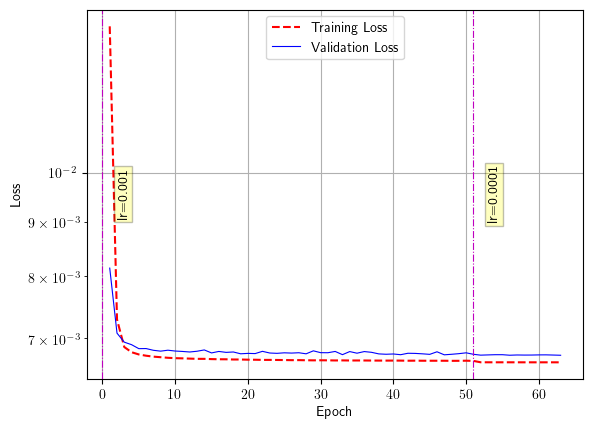

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

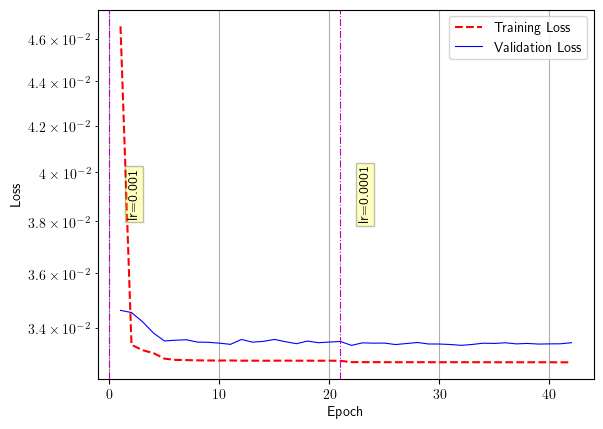

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

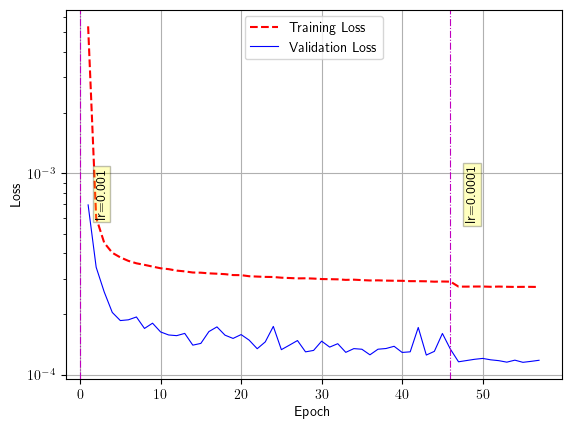

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

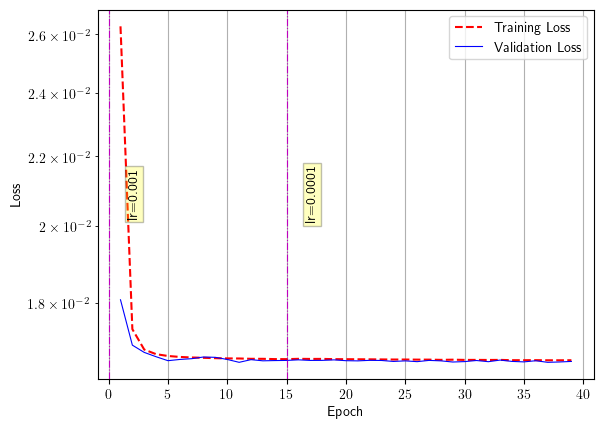

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

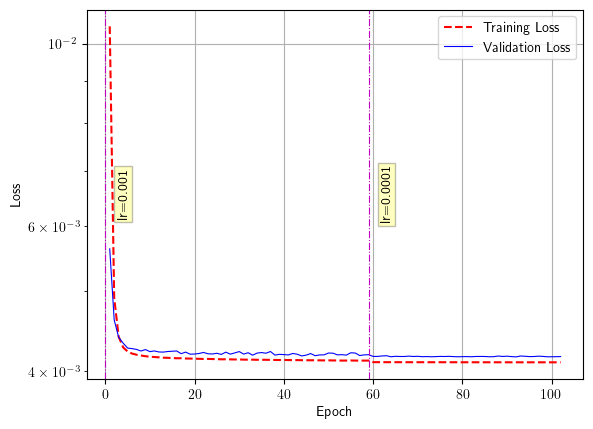

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

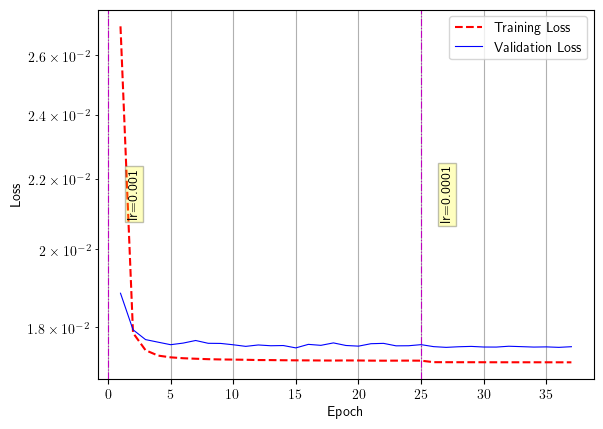

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

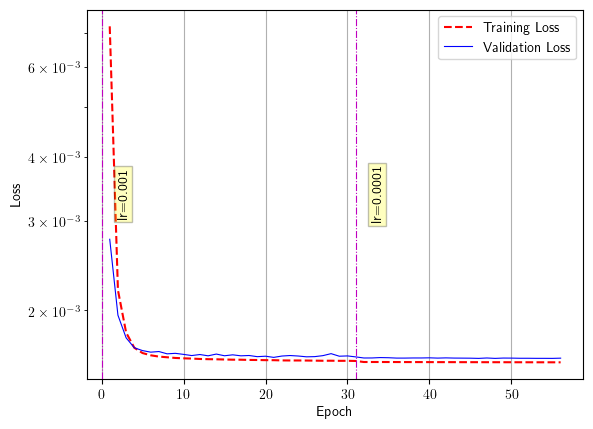

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

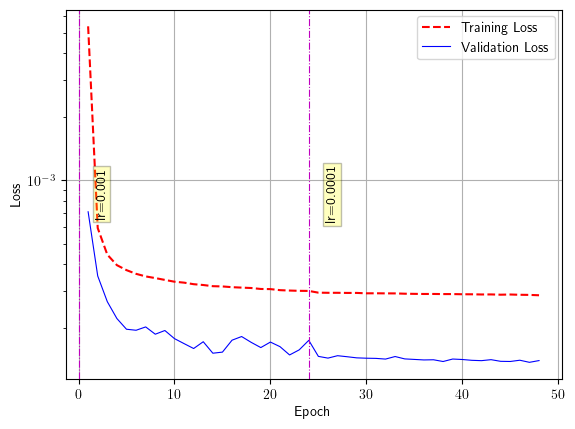

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

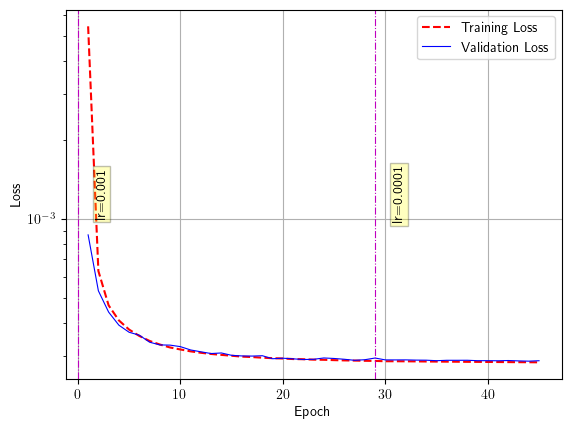

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

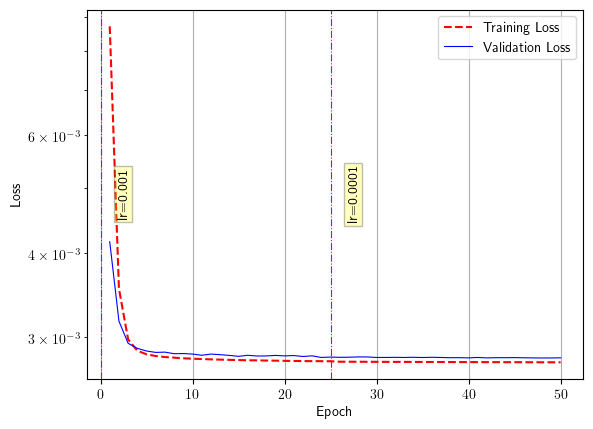

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

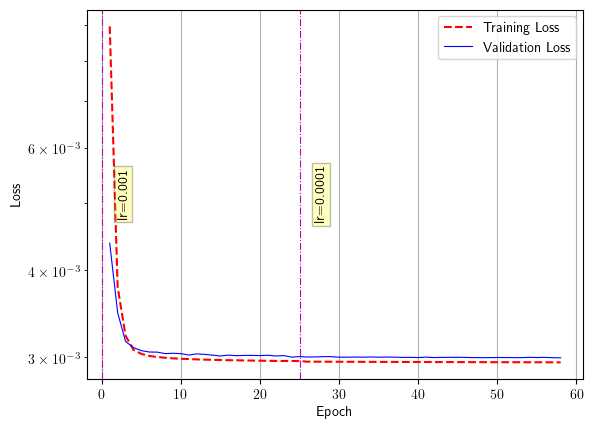

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

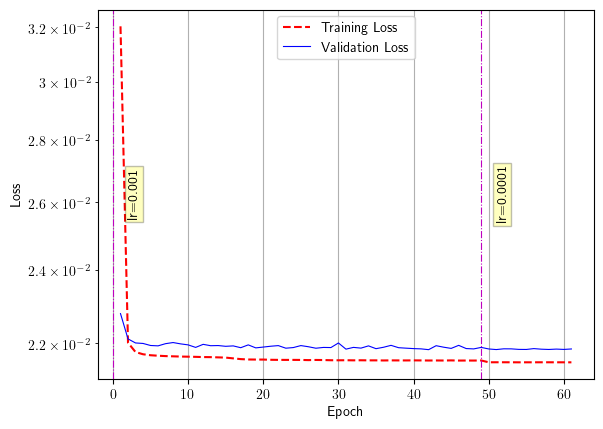

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

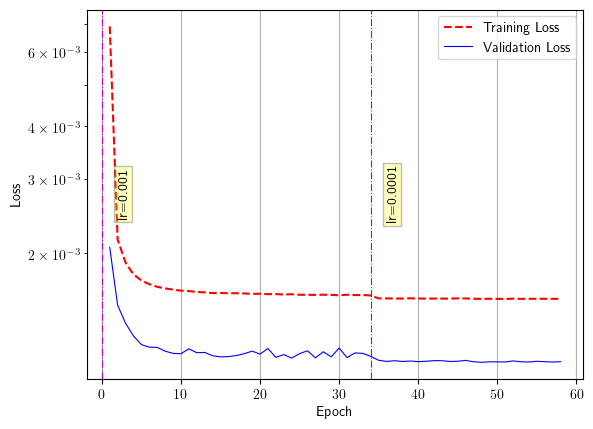

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

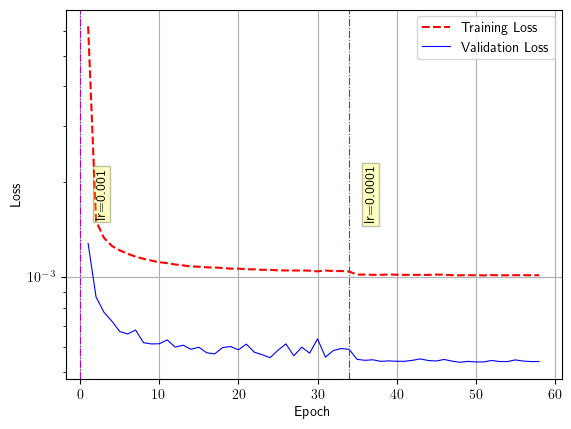

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

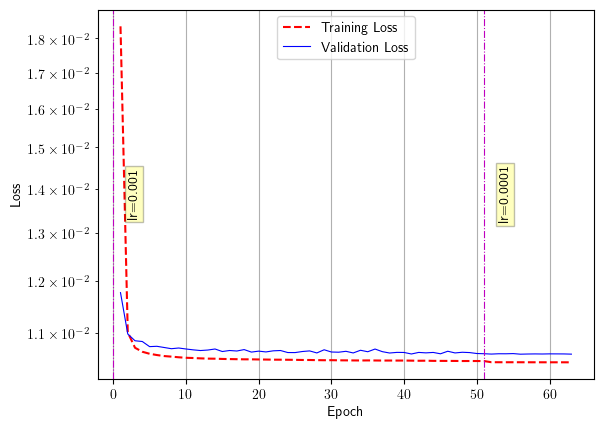

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

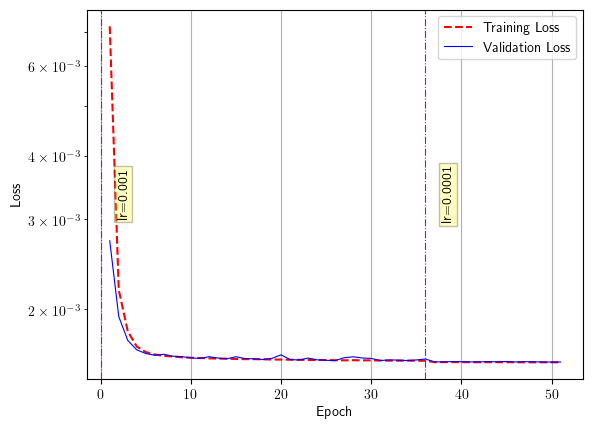

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

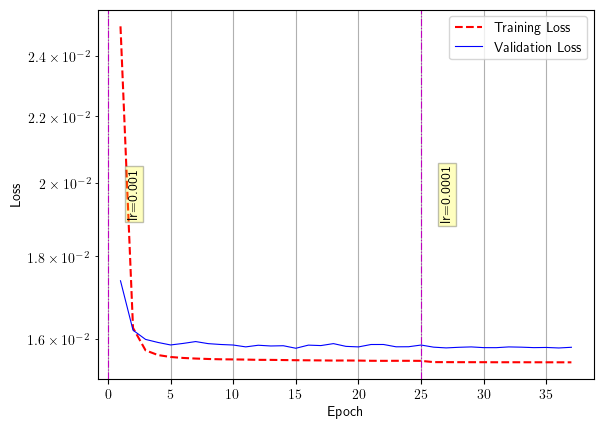

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

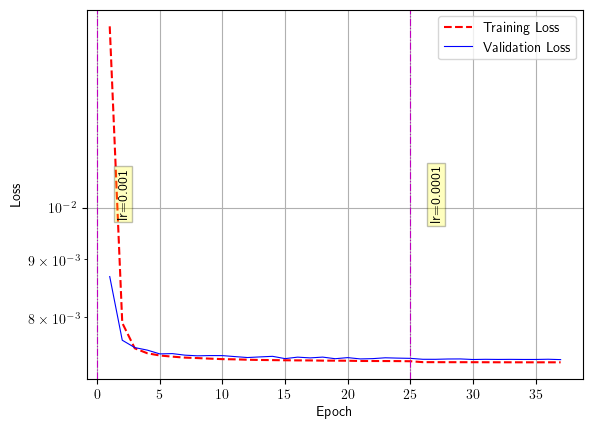

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

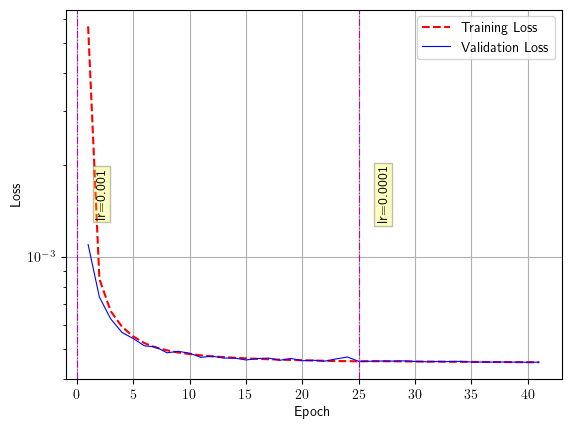

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

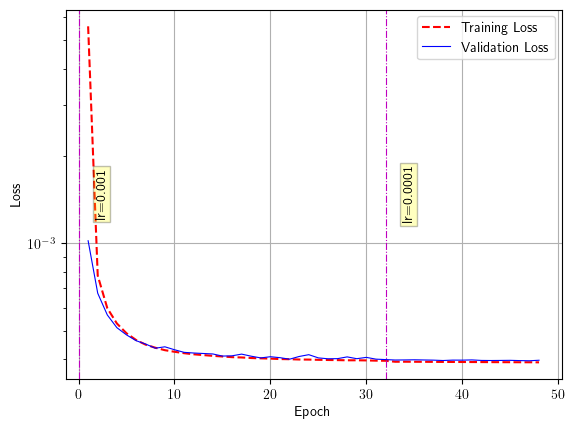

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
res = gp_minimize(
    optim_func,
    [fRMS_bounds, lambda_reg_bounds],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

In [34]:
res

          fun: 2.0152672732365318e-05
    func_vals: array([4.34000285e-05, 3.79082310e-04, 2.01526727e-05, 4.66874008e-05,
       5.62028436e-04, 7.95537431e-04, 8.51250812e-03, 3.92784495e-05,
       3.34892888e-03, 4.28165804e-04, 3.32130888e-03, 1.00605910e-04,
       4.27000305e-05, 2.93691737e-05, 1.76722664e-04, 1.87252415e-04,
       3.70615488e-03, 1.44669131e-04, 1.07284119e-04, 1.19120791e-03,
       1.01024227e-04, 3.19674425e-03, 9.06058762e-04, 4.07850748e-05,
       3.38099380e-05])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542),

In [35]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [36]:
optim_idx

2

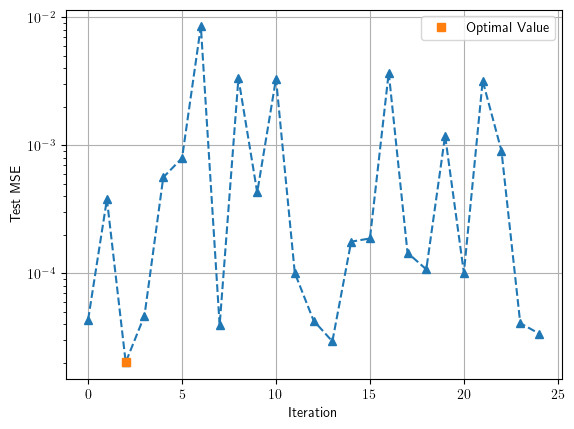

In [37]:
plt.semilogy(func_iters, '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('Test MSE')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/test_mse.png', bbox_inches='tight', dpi=300)
plt.show()

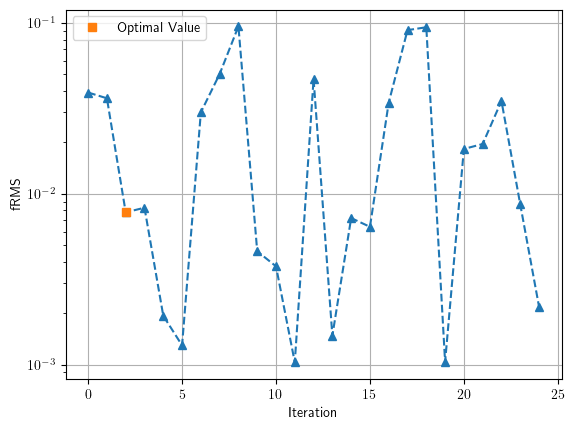

In [38]:
plt.semilogy(x_iters[:, 0], '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [x_iters[optim_idx, 0]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('fRMS')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/fRMS.png', bbox_inches='tight', dpi=300)
plt.show()

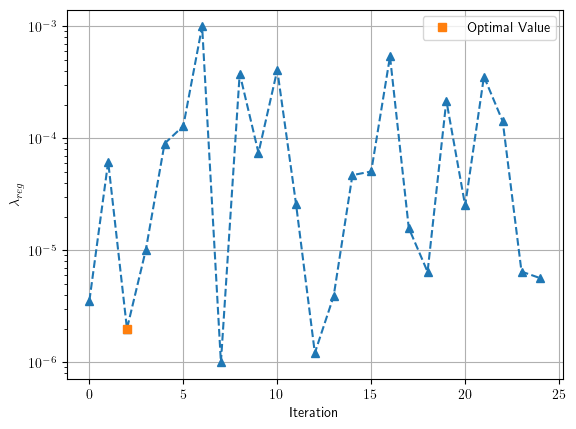

In [39]:
plt.semilogy(x_iters[:, 1], '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [x_iters[optim_idx, 1]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel(r'$\lambda_{reg}$')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/lambda_reg.png', bbox_inches='tight', dpi=300)
plt.show()

In [40]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

# KE and Dissipation